# NLP Project Sectorlense Contract checker

**Projectdescription**

Reviewing software contracts is often a complex and error-prone task, particularly when
assessing standardized requirements and identifying potential risks. Manual contract review
can be time-consuming, leading to inconsistencies and oversight. To address this challenge,
the project aims to develop an LLM-based contract checker that automates the review
process. By leveraging predefined checklists and legal standards, the system will
systematically analyze contracts, ensuring that required clauses are present while also
detecting critical or unusual formulations. This will streamline contract evaluation and
facilitate structured risk assessment, reducing both time and effort for legal professionals
and businesses.

The contract checker will incorporate three primary functionalities. A standard compliance
check will verify whether contracts include the necessary clauses and if they adhere to
established legal and business standards. Assessment based on standardized criteria will
evaluate key contractual aspects to ensure completeness and compliance. Risk identificatalogue_rawion
will highlight non-standard, ambiguous, or high-risk clauses, enabling users to assess their
appropriateness compared to standard contract terms. Additionally, an optional risk
detection feature could be introduced to flag further potential risks that may not be explicitly
covered in the predefined checklist.

The final deliverable will be a web application that enables users to upload contract
documents and receive an automated structured review including insights on compliance
and risk factors. This application will provide detailed feedback, highlight critical sections,
and suggest improvements, making contract review more efficient and reliable.
Development will build upon an existing prototype that includes both a frontend and basic
functionality, allowing for enhancements in accuracy, usability, and scalability.

**Meilensteine**:

Milestone 1: Understanding existing prototype and defining key requirements (Week 1-2)

Milestone 2: Developing/improving NLP-based contract analysis model (Week 3-6)

Milestone 3: Integration into the web application (Week 7-8)

Milestone 4: Testing and evaluation with real-world contracts (Week 9-10)

Milestone 5: Final presentation and documentation (Week 11-12)

**Data**

Contract documents in various formats (PDF, DOCX, TXT). Predefined checklists and legal standards.

In [1]:
# ==============================================================================
#  SYSTEM & ENVIRONMENT
# ==============================================================================
import os
import sys
import ssl
import certifi
import random
import pickle
from pathlib import Path
import time
from dotenv import load_dotenv

# SSL-Config (NLTK, Requests)
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

# ==============================================================================
#  DATA HANDLING
# ==============================================================================
import pandas as pd
import numpy as np

# ==============================================================================
#  TEXT PROCESSING & NLP
# ==============================================================================
import string
import re
from itertools import chain

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import en_core_web_sm

from gensim.parsing.preprocessing import (
    STOPWORDS,
    strip_tags, strip_numeric, strip_punctuation,
    strip_multiple_whitespaces, remove_stopwords,
    strip_short, stem_text
)

from sklearn.feature_extraction.text import CountVectorizer

# ==============================================================================
#  FILE READING & SCRAPING
# ==============================================================================
import pdfplumber
import docx
import requests
from bs4 import BeautifulSoup

# ==============================================================================
#  VISUALIZATION
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display

# ==============================================================================
#  MACHINE LEARNING / DEEP LEARNING
# ==============================================================================
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, recall_score, roc_curve, auc
)
from sklearn.metrics.pairwise import cosine_similarity

# Transformers & Sentence Embeddings
from transformers import (
    BertTokenizer, BertModel,
    AutoTokenizer, AutoModel, AutoConfig
)
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.models import Pooling
import inspect

# ==============================================================================
#  OPENAI API AND JSON HANDLING
# ==============================================================================
from openai import OpenAI
import json

# ==============================================================================
#  REPRODUCIBILITY
# ==============================================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


[nltk_data] Downloading package stopwords to /Users/dave/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Read in Contracts

The contract checker tool that is going to be created in this project needs to be tested and trained based on some real world example contracts. Therefore Sectorelense provided us with an excel sheet containing a list of various providers of Saas solutions and links to their websites where sample contracts are available.

These contract documents appear in various formats. Some of them in HTML, some in PDF, some in DOCX and some in the format of JSON.

To automate the collection of contracts our first approach was to try to build an automated scraping tool for each file format.

## 1.1 Scraping HTML
We Started by creating a scraping tool for HTML websites. After a short time we realised that this woulden´t be as easy as expected, since all the websites appear in different formats which leads to different scraping properties for every website.

However we proceeded and tried to build a seperate scraping function for all the provided websites that seemed to be impactfull to us.

The following code shows scraping functions for different kind of websites. In the end you can find a chooser function, that chooses which scraping functtion to use exactly based on the link provided.

In [ ]:
import re
import requests
from bs4 import BeautifulSoup

# 1. Scraper für Standard-HTML-Verträge
def scrape_html_standard(url):
    try:
        headers = {
            "User-Agent": (
                "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                "AppleWebKit/537.36 (KHTML, like Gecko) "
                "Chrome/122.0.0.0 Safari/537.36"
            )
        }
        response = requests.get(url, headers=headers)
        response.encoding = 'utf-8'
        response.raise_for_status()

        soup = BeautifulSoup(response.text, "html.parser")
        for tag in soup(["script", "style", "header", "footer", "nav"]):
            tag.decompose()

        main_content = soup.find("div", class_="single-content") or soup
        raw_text = main_content.get_text(separator=" ", strip=True)
        full_text = re.sub(r'\s+', ' ', raw_text)

        start_patterns = [r"§\s?\d+", r"1\.\s+[^\n\.]+"]
        for pattern in start_patterns:
            match = re.search(pattern, full_text)
            if match:
                full_text = full_text[match.start():]
                break

        end_markers = [
            "Die eingetragene Marke MOCO", "Stand 12/2024", "Ort, Datum",
            "Unterschrift", "Impressum", "©", "Nachtrag Australische spezifische Begriffe"
        ]
        cutoff = int(len(full_text) * 0.7)
        positions = {m: full_text.find(m) for m in end_markers if full_text.find(m) > cutoff}
        if positions:
            full_text = full_text[:min(positions.values())]

        return full_text.strip()

    except Exception:
        return ""


# 2. Scraper für CommonPaper-Verträge
def scrape_html_commonpaper(url):
    try:
        response = requests.get(url)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, "html.parser")
        content = soup.find("div", class_="entry-content")
        if not content:
            print(f"⚠️ CommonPaper: Kein Hauptbereich gefunden – {url}")
            return ""

        result = []

        def walk_list(ol, prefix=""):
            items = ol.find_all("li", recursive=False)
            for idx, li in enumerate(items, 1):
                number = f"{prefix}.{idx}" if prefix else str(idx)
                li_copy = BeautifulSoup(str(li), "html.parser")
                for sublist in li_copy.find_all("ol"):
                    sublist.decompose()
                text = li_copy.get_text(separator=" ", strip=True)
                result.append(f"{number}. {text}")

                sub_ol = li.find("ol")
                if sub_ol:
                    walk_list(sub_ol, number)

        top_ol = content.find("ol")
        if top_ol:
            walk_list(top_ol)
        else:
            print("⚠️ Keine <ol> gefunden!")

        return "\n".join(result)

    except Exception as e:
        print(f"Fehler beim Scrapen CommonPaper: {e}")
        return ""


# 3. Scraper für Fakturia-Verträge
def scrape_html_fakturia(url):
    try:
        headers = {
            "User-Agent": (
                "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                "AppleWebKit/537.36 (KHTML, like Gecko) "
                "Chrome/122.0.0.0 Safari/537.36"
            )
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, "html.parser")
        content = soup.find("div", class_="entry-content-wrapper")
        if not content:
            print("⚠️ Fakturia: Kein Hauptbereich gefunden.")
            return ""

        result = []
        section = ""

        for elem in content.find_all(["h2", "p"]):
            text = re.sub(r'\s+', ' ', elem.get_text(separator=" ", strip=True))

            if elem.name == "h2":
                if section:
                    result.append(section.strip())
                section = text + "\n"
            elif elem.name == "p":
                if re.match(r'^\d+\.\d+', text):
                    section += text + " "
                else:
                    section += text + "\n"

        if section:
            result.append(section.strip())

        for marker in ["Copyright OSB Alliance e.V.", "gemäß CC BY", "Version 1/2015"]:
            if marker in result[-1]:
                result[-1] = result[-1].split(marker)[0].strip()
                break

        return "\n\n".join(result)

    except Exception as e:
        print(f"Fehler beim Scrapen Fakturia: {e}")
        return ""


# 4. Scraper für Mitratech-Verträge
def scrape_html_mitratech(url):
    try:
        headers = {
            "User-Agent": (
                "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                "AppleWebKit/537.36 (KHTML, like Gecko) "
                "Chrome/122.0.0.0 Safari/537.36"
            )
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, "html.parser")
        for tag in soup(["script", "style", "header", "footer", "nav", "form", "noscript"]):
            tag.decompose()

        main = soup.find("main") or soup
        found = False
        blocks = []

        for el in main.find_all(["h1", "h2", "h3", "p", "li", "ol", "ul"]):
            text = el.get_text(separator=" ", strip=True)
            if not text:
                continue

            if not found and text.startswith("1. Allgemeines"):
                found = True
                blocks.append(text)
                continue

            if found and el.name in ["h1", "h2", "h3"] and "Begriffsbestimmungen" in text:
                break

            if found:
                blocks.append(text)

        return "\n\n".join(blocks).strip()

    except Exception as e:
        print(f"Fehler beim Scrapen Mitratech: {e}")
        return ""


# Automatische Auswahl je nach URL
def scrape_contract_auto(url):
    url_lc = url.lower()
    if "commonpaper.com" in url_lc:
        return scrape_html_commonpaper(url)
    elif "fakturia.de" in url_lc:
        return scrape_html_fakturia(url)
    elif "mitratech.com" in url_lc or "alyne.com" in url_lc:
        return scrape_html_mitratech(url)
    else:
        return scrape_html_standard(url)

## 1.2 Reading in PDF, DOCX and JSON

Since we realised that all the files are delivered in different formats and therefore trying to automate the reading process won´t be really sucsesfull, since you have to write a new function for every document we stopped that approach. If we would continue like this we would have to write a seperate function for each document, considering the slight differences each document comes with.

Since this would consume a lot of time and is not very efficient as prooven by the HTML example we decided to simply copy all the relevant DOCX, PDF and JSON files into TXT files manually. This is because it is way easier for us to read in txt files that are all in the same format.

This project is about NLP and not so much about building automated scraping tools. Therefore we think this apporach is reasonable.

**TXT**

In [ ]:
#Funktion zum einlesen von .txt files
def read_txt_file(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()
        return content
    except Exception as e:
        print(f"Fehler beim Einlesen der Datei: {e}")
        return ""

**Read mapping**

In [ ]:


excel_path = Path("../data/input_mapping/Mappingliste_Verträge.xlsx")
df = pd.read_excel(excel_path)


**Neue Spalte Content und Filetype in DF erzeugen**

In [ ]:
if 'Content' not in df.columns:
    df['Content'] = ""

if 'FileType' not in df.columns:
    df['FileType'] = ""

**TxT files und HTML links automatisiert in Data Frame einlesen und als pickle file speichern**

In [ ]:
# Basisordner für lokale Vertragsdateien
base_path = Path("../data/verträge/verträge_txt")

# Iteration über die Mapping-Tabelle
for idx, row in df.iterrows():
    mapping_field = row['Mapping']
    content = ""
    file_type = ""

    if pd.notna(mapping_field):
        mappings = [m.strip() for m in mapping_field.split(';')]
        texts = []

        for i, mapping in enumerate(mappings):
            if mapping.endswith('.txt'):
                filename = Path(mapping).name  # nur Dateiname
                filepath = base_path / filename
                texts.append(read_txt_file(filepath))
                if i == 0:
                    file_type = "TXT"
            else:
                texts.append(scrape_contract_auto(mapping))
                if i == 0:
                    file_type = "HTML"

        content = "\n\n".join(texts)

    df.at[idx, 'Content'] = content
    df.at[idx, 'FileType'] = file_type



**Englische Texte übersetzen**

In [ ]:

# .env laden für API-Key
load_dotenv()

# src-Ordner zum Pfad hinzufügen, damit translate.py importiert werden kann
sys.path.append(str(Path("..") / "src"))

# Funktion importieren
from translate import translate_dataframe
# Übersetzung auf Texte mit Sprache 'EN' anwenden
df_translated = translate_dataframe(df)


**Fertige input files als pickle file speichern**

In [ ]:
# Ausgabeordner und -datei
output_pickle_path = Path("../data/data_scraped_input.pkl")
# Ergebnisse speichern
df_translated.to_pickle(output_pickle_path)

# 2. Data cleaning
## 2.1 Data Loading and Initial Structuring

In the first step, we load the data from the pickled dataset produced by the data_script_input. After reading in the contracts, each entry in our custom dataset is enriched with key metadata, including:

- the source of the data
- the document type
- a mapping to the original source website
- the language of the document
- the full contract content
- and the file type

This step ensures that all contracts are consistently structured and traceable back to their origin.

In [2]:
df_all_contracts = pd.read_pickle("../data/data_scraped_input.pkl")
display(df_all_contracts.head())

,Kategorie,Quelle/Organisation,Dokumententyp,Mapping,Sprache,Content,FileType
0,Verbände / Templates,IT-Recht Hannover,Muster SaaS-Vertrag,https://it-rechthannover.de/IT-Muster/SaaS-Ver...,DE,§ 1 Vertragsgegenstand 1.1 Der Anbieter stellt...,HTML
1,Verbände / Templates,3H Solutions AG,Standard-Vertragsbedingungen SaaS,Templates_3H_Solutions_AG_18-06_SaaS-Cloudsoft...,DE,Standard-Vertragsbedingungen\nSaaS- und Clouds...,TXT
2,Verbände / Templates,Common Paper,Cloud Service Agreement,https://commonpaper.com/standards/cloud-servic...,EN,1. Service\n1.1. Access and Use. During the Su...,HTML
3,Öffentlich zugängliche Verträge großer SaaS-An...,SAP,NaN,SaaS_SAP_Service_Level_Agreement.txt,DE,SERVICE-LEVEL-VEREINBARUNG FÜR PRIVATE CLOUD E...,TXT
4,Öffentlich zugängliche Verträge großer SaaS-An...,SAP,NaN,Saas_SAP_General_Terms.txt,DE,ALLGEMEINE GESCHÄFTSBEDINGUNGEN FÜR CLOUD SERV...,TXT


**Example of Contract Content:**

In [3]:
df = df_all_contracts
print(df.iloc[13, 5][:1000] + "...")

Vertragsbedingungen SaaS-Vertrag
der TA Triumph-Adler Gruppe (Stand 01/2021)
Vertragsbedingungen SaaS-Vertrag der TA Triumph-Adler Gruppe
(Stand 01/2021) – Seite 1 von 5
1. Vertragsgegenstand, Anwendungsbereich
1.1. Diese „Vertragsbedingungen SaaS-Vertrag TA Triumph-Adler Gruppe“
(„Vertragsbedingungen“) sind Bestandteil des zwischen Auftragnehmer und
Auftraggeber (gemeinsam „Parteien“) abgeschlossenen Software as a
Service-Vertrags („SaaS-Vertrag“).
1.2. Bestandteil des SaaS-Vertrags sind je nach Vereinbarung im SaaS-Vertrag:
a) die entgeltliche Überlassung folgender Objekte:
- Softwareanwendung mittels Internet, soweit keine anderweitige
Telekommunikation ausdrücklich vereinbart wurde („Services“),
- und/oder
- Software („Vertragssoftware“) einschließlich der zugehörigen Beschreibung
der technischen Funktionalität, des Betriebs, der Installation und der Nutzung,
b) die Erbringung von Serviceleistungen an den Services,
c) die Erbringung von Softwarepflege- und -supportleistungen
(„SPS-

## 2.2 Filter and Select Data 
For further data processing, we retain only the content and contract columns, as these contain the essential information for our analysis.

Additionally, we focus exclusively on contracts written in German, since the goal is to develop a German-language contract checker. Filtering by language at this stage ensures consistency and avoids noise from multilingual data.

In [4]:
# filter df to relevant contracts
df_relevant = df[#(df['Kategorie'] == "kleinere SaaS-Anbieter (Hauptgruppe)") & 
                    (df['Sprache'] == "DE") #& (df['Quelle/Organisation'] != "Comarch ERP XT"	)
                    ]
df_relevant = df_relevant.iloc[:,[5]]
df_relevant.columns = ['content']
df_relevant["contract"] = range(1, df_relevant.shape[0] + 1)
df_relevant = df_relevant[['contract', 'content']]


**Example:**

In [5]:

print(df_relevant.head())
with open("../data/data_scraped_input_relevant.pkl", "wb") as f:
    pickle.dump(df_relevant, f)

# Save the DataFrame to an Excel file
df_relevant.to_excel("../data/data_scraped_input_relevant.xlsx", index=False)

   contract                                            content
0         1  § 1 Vertragsgegenstand 1.1 Der Anbieter stellt...
1         2  Standard-Vertragsbedingungen\nSaaS- und Clouds...
3         3  SERVICE-LEVEL-VEREINBARUNG FÜR PRIVATE CLOUD E...
4         4  ALLGEMEINE GESCHÄFTSBEDINGUNGEN FÜR CLOUD SERV...
5         5  SUPPORT SCHEDULE FÜR CLOUD SERVICES\nDieses Su...


## 2.3 Slicing 
Since we aim to analyze individual sections rather than entire contracts, the next step is to split the contract texts into smaller segments. Specifically, we divide each contract into multiple rows, first by paragraphs, and then by subsections within each paragraph. This segmentation makes it possible to process and classify specific parts of the contract more effectively.

In [6]:
def extract_paragraphs_and_sections(row, col='content', contract_col='contract', print_steps = False):
    import re

    text = row[col]
    if contract_col ==None:
        contract_id= 1
    else:
        contract_id = row['contract']
    lines = text.splitlines()
    paragraphs = []
    current_para_lines = []
    current_para_number = 0
    current_para_match = None
    match_pat_type_1 = True
    match_pat_type_2 = True
    match_pat_type_3 = True
    para_mode = None

    # 1. extract paragraphs

    for line in lines:
        line = line.strip()
        if not line:
            continue

        search_for = str(int(current_para_number) + 1)

        
        if para_mode == "symbol":
            if search_for:
                match_main = re.match(rf'§\s*{search_for}(?!\d)', line)
        elif para_mode == "number":
            if search_for:
                match_main = re.match(rf'\b{search_for}\.(?!\d)', line)
        else:
            # Noch kein Modus festgelegt: beides probieren
            match_main = re.match(rf'(§\s*(\d+))(?!\d)|\b(\d+)\.(?!\d)', line)
            if match_main:
                if match_main.group(1):  # § X
                    para_mode = "symbol"
                elif match_main.group(3):  # X.
                    para_mode = "number"
       

        if match_main:
            if current_para_lines:
                paragraphs.append((current_para_number, ' '.join(current_para_lines), current_para_match))
            current_para_number = match_main.group(0).strip().lstrip('§').rstrip('.').strip()  # e.g § 2 lorem ipsum --> 2
            current_para_lines = [line]                                                        # e.g § 2 lorem ipsum --> § 2 lorem impsum
            current_para_match = match_main.group(0).strip()                                   # e.g § 2 lorem ipsum --> § 2
        elif current_para_lines:
            current_para_lines.append(line)

    if current_para_lines:
        paragraphs.append((current_para_number, ' '.join(current_para_lines), current_para_match))

    rows = []
    seen_sections = set()  # (contract_id, para_num, section_id)

    for para_num, para_text, para_match in paragraphs:
        
        if para_mode == "number":
            matches = list(re.finditer(rf'(?:(?<=\s)|(?<=^))({para_num}\.\d{{1}})(?![\dA-Za-z])|\((\d+)\)', para_text))
        if para_mode == "symbol":
            matches = list(re.finditer(rf'(?:(?<=\s)|(?<=^))({para_num}\.\d{{1}})(?![\dA-Za-z])|\((\d+)\)|\b(\d+)\.(?!\d)', para_text))

        if print_steps:
            print(para_num)
            print(seen_sections)
            print(para_text)
            print(matches)
            

        if not matches:
            rows.append({
                'contract': contract_id,
                'paragraph': para_match,
                'paragraph_content': para_text.strip(),
                'section': "no sections use paragraph",
                'section_content': para_text.strip()
            })
            continue

        positions = []
        last_section_number = 0
        

        for match in matches:
            # hole entweder dezimale section (z. B. 1.1) oder Klammer-section (z. B. (1))
            section_id = match.group(1) or match.group(2) or match.group(3)
            start = match.start()

            # Unterscheide die Formate
            if match.group(1) and match_pat_type_1:  # Dezimal: z. B. "1.5"
                try:
                    section_suffix = int(section_id.split(".")[1])
                except (IndexError, ValueError):
                    continue  # überspringen bei Fehler
                match_pat_type_2 = False # If first pattern type detected only look for this one
                match_pat_type_3 = False

                # verbiete z. B. "1.50"
               # if re.match(rf'{para_num}\.\d{{2,}}$', section_id):
                #    continue

            elif match.group(2) and match_pat_type_2:  # Klammer: z. B. "(2)"
                try:
                    section_suffix = int(section_id.strip("()")) 
                    section_id = f'({section_suffix})'  # Einheitliches Format für Ausgabe
                except ValueError:
                    continue
                match_pat_type_1 = False # If second pattern type detected only look for this one
                match_pat_type_3 = False
            elif para_mode == "symbol" and match.group(3) and match_pat_type_3:  # 1. (nur bei mode=symbol)
                if print_steps:
                    print(section_id)
                try:
                    section_suffix = int(section_id.split(".")[0])
                    section_id = f'{section_suffix}.'  # für Klarheit
                except ValueError:
                    continue
                match_pat_type_1 = False # If third pattern type detected only look for this one
                match_pat_type_2 = False

            else:
                continue  # kein gültiges Format

            # Nur nächste Zahl zulassen
            if last_section_number != 0 and section_suffix != last_section_number + 1:
                continue

            section_key = (contract_id, para_num, section_id)
            if section_key in seen_sections:
                continue

            seen_sections.add(section_key)
            positions.append((start, section_id))
            last_section_number = section_suffix


        # Add end position
        positions.append((len(para_text), None))
        positions = sorted(positions)
        if print_steps:
            print(f'positions = {positions}')
            print('###########')

        for i in range(len(positions) - 1):
            start_pos = positions[i][0]
            end_pos = positions[i + 1][0]
            section_id = positions[i][1]
            section_text = para_text[start_pos:end_pos].strip()

            rows.append({
                'contract': contract_id,
                'paragraph': para_match,
                'paragraph_content': para_text.strip(),
                'section': section_id,
                'section_content': section_text
            })

    return rows


**New structure**:

In [7]:
df_exploded = df_relevant.apply(extract_paragraphs_and_sections, axis=1)
print(df_exploded.head())
flattened_rows = list(chain.from_iterable(df_exploded))
df_structured = pd.DataFrame(flattened_rows)
print("               \\#########/")
print("                \\#######/")
print("                 \\#####/")
print("                  \\###/")
print("                   \\#/")


display(df_structured[["contract","paragraph","section"]])

0    [{'contract': 1, 'paragraph': '§ 1', 'paragrap...
1    [{'contract': 2, 'paragraph': '§ 1', 'paragrap...
3    [{'contract': 3, 'paragraph': '1.', 'paragraph...
4    [{'contract': 4, 'paragraph': '1.', 'paragraph...
5    [{'contract': 5, 'paragraph': '1.', 'paragraph...
dtype: object
               \#########/
                \#######/
                 \#####/
                  \###/
                   \#/


,contract,paragraph,section
0,1,§ 1,1.1
1,1,§ 1,1.2
2,1,§ 1,1.3
3,2,§ 1,(1)
4,2,§ 1,(2)
...,...,...,...
1371,26,19.,19.2
1372,26,19.,19.3
1373,26,19.,19.4
1374,26,19.,19.5


In a second step, we aim to extract paragraph titles directly from the paragraph content. To achieve this, we use regular expressions (regex) that match common patterns typically found at the beginning of legal paragraphs—such as numbered clauses, keywords like "Der", "Ein", or "Eine", or capitalized phrases.

Since this is not working totally well and quite often ni recognizable pattern is found, we apply a fallback strategy: we extract a short snippet from the beginning of the paragraph (e.g., the first few words or until the first full sentence) to serve as a temporary title.

This ensures that each paragraph receives a consistent and descriptive title, even if the document does not explicitly define one. These titles are useful for labeling, classification, and structuring contract documents for downstream tasks. Furthermore the Paragraph tag and the number is removed. 

Since we want the later algorithm to focus on the content rather than focusing on the title we also remove the title from the content of the prargraph as well as drom the content of the section

In [8]:
def extract_title_fixed(group):
    import re
    paragraph_text = group['paragraph_content'].iloc[0]
    section_texts = group['section_content'].tolist()

    # No Sections (single paragraph)
    if len(section_texts) == 1 and group['section'].iloc[0] == "no sections use paragraph":
        # find sentence end
        match = re.search(r'\b(Der|Die|Das|Es|Ein|Eine)\s+[A-ZÄÖÜ][a-zäöü]+\b', paragraph_text)
        if match:
            title = paragraph_text[:match.start()].strip()
        else:
            # Fallback: to first verb or 8 words
            title = ' '.join(paragraph_text.split()[:8])
        return pd.Series([title] * len(group), index=group.index)

    # secction split
    for section in section_texts:
        paragraph_text = paragraph_text.replace(section, '')
    title = paragraph_text.strip()
    return pd.Series([title] * len(group), index=group.index)

In [9]:
df_structured['paragraph_title'] = df_structured.groupby(['contract', 'paragraph'], group_keys= False).apply(extract_title_fixed)


df_structured = df_structured[
    ['contract', 'paragraph', 'paragraph_title', 'paragraph_content', 'section', 'section_content']
]


df_structured['paragraph_title'] = df_structured.apply(
    lambda row: row['paragraph_title'].replace(row['paragraph'], '').strip() if pd.notnull(row['paragraph_title']) else '',
    axis=1
)


df_structured["paragraph_content"] = df_structured.apply(
    lambda row: row["paragraph_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["paragraph_content"]) else '',
    axis=1
)

df_structured["section_content"] = df_structured.apply(
    lambda row: row["section_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["section_content"]) else '',
    axis=1
)



/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_8714/3127144179.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_structured['paragraph_title'] = df_structured.groupby(['contract', 'paragraph'], group_keys= False).apply(extract_title_fixed)


**New structure**:

In [10]:
display(df_structured.head())
output_pickle_path = Path("../data/data_structured.pkl")
# Ergebnisse speichern
df_structured.to_pickle(output_pickle_path)
df_structured.to_excel("../data/data_structured.xlsx", index=False)

,contract,paragraph,paragraph_title,paragraph_content,section,section_content
0,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...
1,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...
2,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.3,1.3 Der Kunde erhält ausschließlich das vertra...
3,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...
4,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(2),(2) Die Software wird vom Anbieter als webbasi...


## 2.3 Cleaning

In the next step, we focused on cleaning and normalizing the core of the dataset. For this purpose, we implemented a flexible function that allows us to experiment with various cleaning strategies via parameters. These options include:

- Removing all paragraph markers (e.g., “§”, “1.2”)
- Converting all text to lowercase
- Stripping HTML tags
- Removing numbers
- Removing punctuation
- Reducing multiple whitespaces to a single space
- Removing short words (e.g., ≤ 2 characters)
- Removing known stopwords (using Gensim’s stopword library)
- Applying stemming to reduce words to their root form

We tested various combinations of these settings across multiple runs. The best results were achieved with all cleaning steps enabled, except for stemming, which tended to distort meaning too much in our context.

Therefore, we adopted this configuration as our standard cleaning approach going forward.



In [11]:
df_structured = pd.read_pickle("../data/data_structured.pkl")
display(df_structured.head())

,contract,paragraph,paragraph_title,paragraph_content,section,section_content
0,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...
1,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...
2,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.3,1.3 Der Kunde erhält ausschließlich das vertra...
3,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...
4,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(2),(2) Die Software wird vom Anbieter als webbasi...


In [12]:
def clean_contract_text(
    text,
    remove_paragraph_markers=True,
    to_lower=True,
    remove_tags=True,
    remove_numbers=True,
    remove_punctuation=True,
    remove_extra_whitespace=True,
    strip_short_words=False,
    remove_stopwords =False,
    apply_stemming=False
):
    if not isinstance(text, str):
        return ""

    if to_lower:
        text = text.lower()

    if remove_paragraph_markers:
        # Remove paragraph indicators like "§ 1", "1.", "1.1" etc.
        text = re.sub(r'^(§?\s*\d+[a-zA-Z]*[.)]?(\s*\(?\d+[.)]?)?)', '', text)
        text = re.sub(r'\(?\b\d{1,2}(\.\d{1,2})?\)?', '', text)

    if remove_tags:
        text = strip_tags(text)

    if remove_numbers:
        text = strip_numeric(text)

    if remove_punctuation:
        text = strip_punctuation(text)

    if remove_extra_whitespace:
        text = strip_multiple_whitespaces(text)

    if strip_short_words:
        text = strip_short(text, minsize=3)

    if remove_stopwords:
        text = remove_stopwords(text, stopwords=STOPWORDS) # !!!!!! Englische Stopwörter  !!!!!!!

    if apply_stemming:
        text = stem_text(text)

    return text.strip()


**appling the function with deaults**:

In [13]:
df_structured["clean_paragraph_content"] = df_structured["paragraph_content"].apply(clean_contract_text)
df_structured["clean_section_content"] = df_structured["section_content"].apply(clean_contract_text)


Example clean paragraph:

In [14]:
print(df_structured["clean_paragraph_content"][0][:150] + "...")

der anbieter stellt dem kunden die software name der software zur verfügung die über eine cloud infrastruktur zugänglich ist die nutzung umfasst die b...


Example clean section:

In [15]:

print(df_structured["clean_section_content"][1][:150] + "...")

die nutzung umfasst die bereitstellung von funktionen speicherplatz und den zugriff über einen webbrowser oder eine entsprechende applikation...


# 2.4 Visualizing Token Distributions with Word Clouds
To gain a better understanding of the most common words and tokens used across the contracts—at the session and paragraph level—we plan to generate several word clouds.

These visualizations will be based on different tokenization stages, including:

- Raw tokenization (including punctuation and original casing),
- Stemming, and
- Lemmatization

By comparing these different views, we aim to identify frequently used legal terms, recurring patterns, and potentially meaningful vocabulary that could inform our downstream tasks such as classification, clustering, or contract clause extraction.

In [16]:
%matplotlib inline
nlp = en_core_web_sm.load()
bert_uncased_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mlparaphrase_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")


### paragraphs
df_structured["paragraph_content_stemm"]=df_structured['clean_paragraph_content'].apply(
    lambda text: stem_text(text)
)
df_structured["paragraph_content_lemma"]=df_structured['clean_paragraph_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)
df_structured["paragraph_content_token_bert"]=df_structured['clean_paragraph_content'].apply(
    lambda text: bert_uncased_tokenizer.tokenize(text)
)

df_structured["paragraph_content_token_mlp"]=df_structured['clean_paragraph_content'].apply(
    lambda text: mlparaphrase_tokenizer.tokenize(text)
)

### sections

df_structured["section_content_stemm"]=df_structured['clean_section_content'].apply(
    lambda text: stem_text(text)
)
df_structured["paragraph_section_lemma"]=df_structured['clean_section_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)
df_structured["paragraph_section_token_bert"]=df_structured['clean_section_content'].apply(
    lambda text: bert_uncased_tokenizer.tokenize(text)
)

df_structured["paragraph_section_token_mlp"]=df_structured['clean_section_content'].apply(
    lambda text: mlparaphrase_tokenizer.tokenize(text)
)


df_clean = df_structured.copy()

columns_and_titles = [
    ("paragraph_content_stemm", "Paragraph – Stemmed"),
    ("paragraph_content_lemma", "Paragraph – Lemmatized"),
    ("paragraph_content_token_bert", "Paragraph – BERT Tokens"),
    ("paragraph_content_token_mlp", "Paragraph – Mulitlingual Paraphrase Tokens"),
    ("section_content_stemm", "Section – Stemmed"),
    ("paragraph_section_lemma", "Section – Lemmatized"),
    ("paragraph_section_token_bert", "Section – BERT Tokens"),
    ("paragraph_section_token_mlp", "Section – Mulitlingual Paraphrase Tokens"),
]


tab_contents = []

for col, title in columns_and_titles:
    output = widgets.Output()
    with output:
        # Join tokens for token-based columns, else join raw text
        if "token" in col:
            all_text = " ".join([" ".join(tokens) if isinstance(tokens, list) else str(tokens)
                                for tokens in df_structured[col].dropna()])
        else:
            all_text = " ".join(df_structured[col].dropna())

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Wordcloud – {title}", fontsize=16)
        plt.show()
        plt.close() 

        tab_contents.append((title, output))

# Tabs erzeugen

tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)

display(tab_widget)





Token indices sequence length is longer than the specified maximum sequence length for this model (1091 > 512). Running this sequence through the model will result in indexing errors


===> Save cleaned Contract content

In [17]:
file_path = '../data/data_clean.pkl'  
df_clean.to_pickle(file_path)
df_clean.to_excel("../data/data_clean.xlsx", index=False)

# 3. Labeling
## 3.1 Catalog cleaning
In the next step, our goal is to assign labels to as many of our contract sections as possible, based on a predefined requirement catalog.
The requirement catalog consists of the following three components:

- Paragraph Topic: This indicates which paragraph or general area of the contract the requirement refers to.
- Section Topic: A short guiding question that describes the specific aspect or issue that should be addressed within that section of the contract.
- Example Sentence: A concrete example taken from an actual SaaS contract that illustrates how this requirement might typically be formulated in legal language.

This structured setup allows us to later match contract content to catalog entries based on thematic and semantic similarity.

However, before we can map the requirement catalog to our contract data, we first need to clean the example phrases (reference texts) contained within the catalog itself. These examples need to go through the same preprocessing pipeline, such as lowercasing, punctuation removal, and stopword filtering, to ensure that the label mapping is accurate and consistent with the processed contract content.

Only once both the contract data and the catalog examples are cleaned can we begin matching them effectively for label assignment.

**<=== load the raw catalogue**

In [18]:
catalogue_raw = pd.read_excel("../data/catalogue_raw.xlsx")
display(catalogue_raw)


,paragraph_topic,section_topic,example
0,Projektkosten & Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,„Im Festpreis von 200.000 € sind sämtliche Lei...
1,Projektkosten & Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,„Der Kunde zahlt eine monatliche Pauschale von...
2,Projektkosten & Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,„Die Vergütung ist in drei Raten zahlbar: 30% ...
3,Projektkosten & Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",„Alle Preise verstehen sich in Euro zuzüglich ...
4,Projektkosten & Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,„Reise- und Übernachtungskosten werden nur ers...
...,...,...,...
71,Sonstige wichtige Klauseln,Ist die anwendbare Rechtsordnung eindeutig ver...,„Dieser Vertrag unterliegt dem Recht der Bunde...
72,Sonstige wichtige Klauseln,Ist ein Gerichtsstand für Streitigkeiten festg...,„Gerichtsstand für alle Streitigkeiten aus ode...
73,Sonstige wichtige Klauseln,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",„Dieser Vertrag wird in deutscher und englisch...
74,Sonstige wichtige Klauseln,Enthält der Vertrag eine salvatorische Klausel...,„Sollte eine Bestimmung dieses Vertrages unwir...


In [19]:

catalogue_raw["example"] = catalogue_raw["example"].str.strip('„“"').apply(clean_contract_text)
catalogue_raw["paragraph_topic"] = catalogue_raw["paragraph_topic"].apply(
    lambda x: x.replace("&", 'und').strip().replace(" ","_")
)

catalogue_clean= catalogue_raw.copy()

display(catalogue_raw.head())

file_path = '../data/catalogue_clean.pkl'  
catalogue_clean.to_pickle(file_path)
catalogue_clean.to_excel("../data/catalogue_clean.xlsx", index=False)



,paragraph_topic,section_topic,example
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...


## 3.2 Embedings 
### Reusable Embedding Function for Multiple Models
Since we plan to experiment with various models throughout the project, and each model generates different embeddings, we created a reusable function that adds a new column to a given dataset. This column contains the embeddings computed by the specified model, based on a target text column. This setup allows us to easily switch between models and store their outputs for further analysis or comparison.

In [20]:
def embed_text_column(df, text_column, model, target_column, batch_size=16):
    """
    Computes SentenceTransformer embeddings column-wise in batches, optimized for CPU performance.
    """
    texts = df[text_column].fillna("").tolist()
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc=f"Embedding {text_column}"):
        batch = texts[i:i+batch_size]
        with torch.no_grad():
            emb = model.encode(batch, convert_to_tensor=True)
        all_embeddings.extend(emb.cpu().numpy())

    df[target_column] = all_embeddings
    return df

## 3.3 Initial Labeling via Embedding Similarity (Deprecated Due to Data Leakage)
Our initial approach was to label the dataset using cosine similarity between contract embeddings and requirement catalog examples, based on a selected model and only doublecheked by a human. The idea was to use these labels later to evaluate and compare different classification models.

However, as the project progressed, we realized that this method introduced data leakage, since the same embeddings used for labeling were also used during model evaluation. To avoid biased results, we decided to abandon this approach in favor of a more robust labeling strategy.

Nevertheless, for the sake of completeness, the original method is documented below.

**<=== load data_clean**


In [21]:
path = '../data/data_clean.pkl'
train_data_unlabeled = pd.read_pickle(path)

# Set seed and sample data
random.seed(2211)
sample_indices = random.sample(range(len(train_data_unlabeled["clean_section_content"])), k=600)

# Choose the model to evaluate
model = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model_name = "multilingual_paraphrase_sentence"

# Copy and sample data
train_data_labeled = train_data_unlabeled.iloc[sample_indices, :].copy()

model = models.Transformer(model, max_seq_length=512)

pooling_model = models.Pooling(
            model.get_word_embedding_dimension(),
            pooling_mode_cls_token=False,           
            pooling_mode_mean_tokens=True,         # ✅ Mean laut chat gpt besser für semantische übereinstimmung
            pooling_mode_max_tokens=False,
        )

model = SentenceTransformer(modules=[model, pooling_model])

# Embed contract sections
train_data_labeled = embed_text_column(
    train_data_labeled,
    text_column="clean_section_content",
    model= model,
    target_column=f"section_em_{model_name}"
)
print(catalogue_clean)

# Embed catalog examples
catalogue = embed_text_column(
    catalogue_clean,
    text_column="example",
    model=model,
    target_column="emb"
)

# Keep only relevant columns
train_data_labeled = train_data_labeled[["contract", "paragraph", "section", "clean_section_content", f"section_em_{model_name}"]]

# Compute cosine similarity
X = np.vstack(train_data_labeled[f"section_em_{model_name}"].values)
Y = np.vstack(catalogue["emb"].values)
similarity_matrix = cosine_similarity(X, Y)
similarity_percent = np.round(similarity_matrix * 100, 2)

# Best matches per section
best_match_idx = similarity_matrix.argmax(axis=1)
best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

# Store results
train_data_labeled[f"matched_example_index_{model_name}"] = best_match_idx
train_data_labeled[f"similarity_percent_{model_name}"] = best_match_score
train_data_labeled[f"matched_example_text_{model_name}"] = catalogue.loc[best_match_idx, "example"].values
train_data_labeled[f"matched_example_topic_{model_name}"] = catalogue.loc[best_match_idx, "section_topic"].values
train_data_labeled[f"matched_paragraph_{model_name}"] = catalogue.loc[best_match_idx, "paragraph_topic"].values

# Summary stats
print(f"# {model_name}")
print("    mean similarity:", train_data_labeled[f"similarity_percent_{model_name}"].mean())
print("    max similarity:", train_data_labeled[f"similarity_percent_{model_name}"].max())
print("    min similarity:", train_data_labeled[f"similarity_percent_{model_name}"].min())

# Example: best and worst match
train_data_labeled_sorted = train_data_labeled.sort_values(f"similarity_percent_{model_name}", ascending=False)
best_match = train_data_labeled_sorted.iloc[0]
print("\nBest match:")
print(f'{best_match["clean_section_content"]} \n### to ### \n{best_match[f"matched_example_text_{model_name}"]} \n### with score ### {best_match[f"similarity_percent_{model_name}"]}')

train_data_labeled_sorted = train_data_labeled.sort_values(f"similarity_percent_{model_name}", ascending=True)
worst_match = train_data_labeled_sorted.iloc[0]
print("\nWorst match:")
print(f'{worst_match["clean_section_content"]} \n### to ### \n{worst_match[f"matched_example_text_{model_name}"]} \n### with score ### {worst_match[f"similarity_percent_{model_name}"]}')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Embedding clean_section_content: 100%|██████████| 38/38 [00:30<00:00,  1.26it/s]


                          paragraph_topic  \
0   Projektkosten_und_Zahlungsmodalitäten   
1   Projektkosten_und_Zahlungsmodalitäten   
2   Projektkosten_und_Zahlungsmodalitäten   
3   Projektkosten_und_Zahlungsmodalitäten   
4   Projektkosten_und_Zahlungsmodalitäten   
..                                    ...   
71             Sonstige_wichtige_Klauseln   
72             Sonstige_wichtige_Klauseln   
73             Sonstige_wichtige_Klauseln   
74             Sonstige_wichtige_Klauseln   
75             Sonstige_wichtige_Klauseln   

                                        section_topic  \
0   Sind sämtliche Kostenarten und -bestandteile (...   
1   Ist das Vergütungsmodell eindeutig festgelegt ...   
2   Ist ein Zahlungsplan mit konkreten Fälligkeite...   
3   Sind Währung, Rechnungsstellung, Zahlungsfrist...   
4   Regelt der Vertrag den Umgang mit Nebenkosten ...   
..                                                ...   
71  Ist die anwendbare Rechtsordnung eindeutig ver...   
72 

Embedding example: 100%|██████████| 5/5 [00:00<00:00,  5.42it/s]

# multilingual_paraphrase_sentence
    mean similarity: 66.95322
    max similarity: 95.97
    min similarity: 22.23

Best match:
sollten einzelne bestimmungen dieses vertrags ganz oder teilweise unwirksam sein oder werden wird die wirksamkeit der übrigen bestimmungen hierdurch nicht berührt die parteien verpflichten sich für diesen fall die ungültige bestimmung durch eine wirksame bestimmung zu ersetzen die dem wirtschaftlichen zweck der ungültigen bestimmung möglichst nahekommt entsprechendes gilt für etwaige lücken dieser bedingungen 
### to ### 
sollte eine bestimmung dieses vertrages unwirksam oder undurchführbar sein oder werden bleibt die wirksamkeit der übrigen bestimmungen hiervon unberührt die parteien werden die unwirksame bestimmung einvernehmlich durch eine solche regelung ersetzen die dem wirtschaftlichen zweck der unwirksamen bestimmung am nächsten kommt 
### with score ### 95.97000122070312

Worst match:
allgemeinen geschäftsbedingungen für die comarch service produkte 

This results in a dataset containing the best matches between contract sections and catalog examples for mulitlingual paraphrase models.

In [22]:
display(train_data_labeled_sorted.sort_values(f"similarity_percent_{model_name}", ascending=False).head(5))

subset = train_data_labeled_sorted[['clean_section_content',"similarity_percent_multilingual_paraphrase_sentence", 'matched_example_text_multilingual_paraphrase_sentence']].sort_values("similarity_percent_multilingual_paraphrase_sentence", ascending=False)

def wrap_text(df, columns):
    return df.style.set_properties(**{
        'white-space': 'pre-wrap',
        'word-wrap': 'break-word'
    }, subset=columns)

# Example: wrap long text in 2 columns
wrap_text(subset.head(5), ['clean_section_content', 'matched_example_text_multilingual_paraphrase_sentence'])

len(catalogue)


,contract,paragraph,section,clean_section_content,section_em_multilingual_paraphrase_sentence,matched_example_index_multilingual_paraphrase_sentence,similarity_percent_multilingual_paraphrase_sentence,matched_example_text_multilingual_paraphrase_sentence,matched_example_topic_multilingual_paraphrase_sentence,matched_paragraph_multilingual_paraphrase_sentence
305,8,15.,15.5,sollten einzelne bestimmungen dieses vertrags ...,"[-0.0041314946, 0.096693866, -0.13690825, -0.0...",74,95.970001,sollte eine bestimmung dieses vertrages unwirk...,Enthält der Vertrag eine salvatorische Klausel...,Sonstige_wichtige_Klauseln
683,16,14.,14.2,der vertrag untersteht dem recht der bundesrep...,"[-0.09444846, 0.19770819, -0.38321418, -0.1446...",71,93.180000,dieser vertrag unterliegt dem recht der bundes...,Ist die anwendbare Rechtsordnung eindeutig ver...,Sonstige_wichtige_Klauseln
142,6,4.,4.1,aufgrund dieses vertrags dürfen die parteien s...,"[-0.05984672, 0.04162008, -0.55982614, -0.0669...",35,93.180000,die parteien verpflichten sich alle ihnen im r...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit
1219,24,§ 19,19.3,sollten teile dieses vertrages ganz oder teilw...,"[-0.076217115, 0.06346369, -0.16947885, 0.0086...",74,92.820000,sollte eine bestimmung dieses vertrages unwirk...,Enthält der Vertrag eine salvatorische Klausel...,Sonstige_wichtige_Klauseln
286,8,11.,11.1,die parteien verpflichten sich alle vertraulic...,"[-0.052296683, 0.086999364, -0.53502244, -0.11...",35,92.269997,die parteien verpflichten sich alle ihnen im r...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit


76

## 3.4 Manual mapping

However, as previously mentioned, the automatic labeling approach introduced data leakage. Therefore, we changed our strategy and switched to manual labeling of as many data points as possible.

Since this process is extremely time-consuming, and we are not legal experts — even in our native language, German — we were only able to manually label a total of 64 data samples.

Another challenge we encountered was that, although we had compiled a dataset of over 1,300 contract sections, we were unable to find suitable matches for all examples in the requirements catalog. As a result, 12 out of the 76 requirement items remain without any corresponding training data.

In essence, we manually reviewed all available contracts and initially searched for relevant keywords to identify potential matches. Once potential sections were found, we compared them directly to the example sections in the requirement catalog.

Only when we were 100% confident that a contract section semantically matched a catalog entry did we assign the corresponding catalog ID (i.e., the position of the example section within the catalog) to that contract section.

The following table shows a selection of sections from our dataset that have been mapped to their corresponding catalog_id (i.e., the index of the requirements catalog).

In [23]:
df_unlabeled = pd.read_pickle("../data/data_clean.pkl")
df_unlabeled = df_unlabeled[["contract","paragraph","section","section_content","clean_section_content"]]
display(df_unlabeled)


mapping = pd.read_excel("../data/mapping_human.xlsx")
print(mapping.head())
mapping = mapping[["contract","paragraph", "section","section_content","catalog_id"]]
display(mapping)

# Merge on both 'paragraph' and 'section' for more precise matching
df_labeled = mapping.merge(df_unlabeled, how="left", on=["contract","paragraph", "section"])
df_labeled= df_labeled[["contract","paragraph","section","clean_section_content","catalog_id"]]
display(df_labeled)

catalogue = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue["catalog_id"] = range(1, len(catalogue) + 1)
display(catalogue)

,contract,paragraph,section,section_content,clean_section_content
0,1,§ 1,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...,der anbieter stellt dem kunden die software na...
1,1,§ 1,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...,die nutzung umfasst die bereitstellung von fun...
2,1,§ 1,1.3,1.3 Der Kunde erhält ausschließlich das vertra...,der kunde erhält ausschließlich das vertraglic...
3,2,§ 1,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...,dieser software as a service vertrag ist auf o...
4,2,§ 1,(2),(2) Die Software wird vom Anbieter als webbasi...,die software wird vom anbieter als webbasierte...
...,...,...,...,...,...
1371,26,19.,19.2,"19.2 Anhänge sind in ihrer jeweils gültigen, d...",anhänge sind in ihrer jeweils gültigen d h von...
1372,26,19.,19.3,19.3 Nebenbestimmungen außerhalb dieses Vertra...,nebenbestimmungen außerhalb dieses vertrags un...
1373,26,19.,19.4,19.4 Die etwaige Unwirksamkeit einzelner Besti...,die etwaige unwirksamkeit einzelner bestimmung...
1374,26,19.,19.5,19.5 Ergeben sich in der praktischen Infrastru...,ergeben sich in der praktischen infrastruktur ...


   contract paragraph                               paragraph_title section  \
0         2       § 7                                     Vergütung     (1)   
1         2      § 12  Vertragslaufzeit und Beendigung des Vertrags     (2)   
2         4        3.        SAP VERANTWORTLICHKEITEN UND PFLICHTEN     3.2   
3         4        5.                         VERGÜTUNG UND STEUERN     5.2   
4         4        6.                        LAUFZEIT UND KÜNDIGUNG     6.3   

                                     section_content  catalog_id  
0  (1) Zahlungszeitraum und Höhe der Vergütung ri...           1  
1  (2) Die außerordentliche Kündigung aus wichtig...          69  
2  3.2. Support und SLA 3.2.1. SAP erbringt Suppo...          31  
3  5.2. Alle Vergütungen unterliegen den jeweils ...           8  
4  6.3. Im Falle einer Kündigung des Auftraggeber...          70  


,contract,paragraph,section,section_content,catalog_id
0,2,§ 7,(1),(1) Zahlungszeitraum und Höhe der Vergütung ri...,1
1,2,§ 12,(2),(2) Die außerordentliche Kündigung aus wichtig...,69
2,4,3.,3.2,3.2. Support und SLA 3.2.1. SAP erbringt Suppo...,31
3,4,5.,5.2,5.2. Alle Vergütungen unterliegen den jeweils ...,8
4,4,6.,6.3,6.3. Im Falle einer Kündigung des Auftraggeber...,70
...,...,...,...,...,...
59,26,16.,16.1,16.1 Das Vertragsverhältnis beginnt mit dem Zu...,68
60,26,17.,17.1,17.1 Vorzeitige Beendigung des Vertrages wegen...,57
61,26,17.,17.3,17.3 Pflichten von 4SELLERS 4SELLERS unterstüt...,58
62,26,17.,17.6,17.6 Datenlöschung nach Vollzug des Wechsels 4...,59


,contract,paragraph,section,clean_section_content,catalog_id
0,2,§ 7,(1),zahlungszeitraum und höhe der richten sich ebe...,1
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,69
2,4,3.,3.2,support und sla sap erbringt support für den c...,31
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,8
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,70
...,...,...,...,...,...
59,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,68
60,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,57
61,26,17.,17.3,pflichten von sellers sellers unterstützt den ...,58
62,26,17.,17.6,datenlöschung nach vollzug des wechsels seller...,59


,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...,5
...,...,...,...,...
71,Sonstige_wichtige_Klauseln,Ist die anwendbare Rechtsordnung eindeutig ver...,dieser vertrag unterliegt dem recht der bundes...,72
72,Sonstige_wichtige_Klauseln,Ist ein Gerichtsstand für Streitigkeiten festg...,gerichtsstand für alle streitigkeiten aus oder...,73
73,Sonstige_wichtige_Klauseln,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",dieser vertrag wird in deutscher und englische...,74
74,Sonstige_wichtige_Klauseln,Enthält der Vertrag eine salvatorische Klausel...,sollte eine bestimmung dieses vertrages unwirk...,75


# 4. Model Comparrison & Evaluation
We now move on to selecting the most suitable model. In total, we chose five different models from Hugging Face, all of which are Sentence Transformers, each with a corresponding tokenizer:

- "deepset/gbert-base"
- "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
- "bert-base-uncased",
- "jinaai/jina-embeddings-v2-small-en",
- "jinaai/jina-embeddings-v2-base-de",


Additionally, we need to decide on a pooling strategy. This strategy determines how we aggregate token-level embeddings into a single section-level embedding, which is essential for comparing sections rather than individual words.
When generating embeddings for full sections using transformer-based models, we must reduce the token-level output to a single fixed-size vector. This process is called pooling. Two common strategies are:

**CLS Token Pooling**
Uses the embedding of the special [CLS] token, which is prepended to every input by models like BERT.
The [CLS] token is explicitly trained (during pretraining) to capture the meaning of the entire sentence for classification tasks.
Advantage: In models trained for classification (e.g. BERT), the CLS token often encodes global sentence-level semantics efficiently.

**Mean Pooling**
Averages the embeddings of all tokens (excluding padding).
Provides a more balanced representation of the entire sentence or section.
Advantage: Especially useful in models not fine-tuned with CLS-specific objectives (e.g. multilingual or paraphrase models), where the semantic information is more evenly distributed across all tokens.

**Max Pooling**
Takes the maximum value across all token embeddings for each embedding dimension (excluding padding).
This emphasizes the most salient features that appear anywhere in the input, regardless of position.

Advantage: Max pooling can highlight strong semantic signals (e.g. key terms) by preserving their peak activations. This may be beneficial in tasks where individual high-impact words (rather than holistic meaning) are important — especially in longer or noisy texts.



## 4.1 Tokenizers and Embeddings

In [24]:
import warnings
model_names = [
    "gbert-base",
    "paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jina-embeddings-v2-small-en",
    "jina-embeddings-v2-base-de"
]



model_urls = [
    "deepset/gbert-base",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jinaai/jina-embeddings-v2-small-en",
    "jinaai/jina-embeddings-v2-base-de"
]


max_tokens = []

for model_name, model_url in zip(model_names, model_urls):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = AutoModel.from_pretrained(model_url)
    
    max_len = model.embeddings.position_embeddings.weight.shape[0]
    max_tokens.append((model_name, max_len))
print("##### ##### #### #### #### ")
print(" ")
for model_name, max_token in zip(model_names, max_tokens):
    print(f'{model_name} --> max tokens = {max_token}')

#### Hier noch beschreieben warum wir diese 5 getestet haben


Some weights of the model checkpoint at deepset/gbert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 

##### ##### #### #### #### 
 
gbert-base --> max tokens = ('gbert-base', 512)
paraphrase-multilingual-MiniLM-L12-v2 --> max tokens = ('paraphrase-multilingual-MiniLM-L12-v2', 512)
bert-base-uncased --> max tokens = ('bert-base-uncased', 512)
jina-embeddings-v2-small-en --> max tokens = ('jina-embeddings-v2-small-en', 8192)
jina-embeddings-v2-base-de --> max tokens = ('jina-embeddings-v2-base-de', 8192)


The following diagram shows how many tokens the various language models generate for the texts in our dataset. It is clearly noticeable that English-based models tend to produce a higher token density, especially for longer texts. A likely reason for this is that German words are not well represented in the English vocabulary, which leads to more frequent splitting into subword tokens.

The two models bert-base-uncase and jina-embeddings-v2-small-en generate much more tokens per text segment compared to the German-language models such as gbert-base and jina-embeddings-v2-base-de.

Nevertheless, all models, including the English ones, achieve consistently solid performance. The fact that many texts exceed the maximum token input size of the respective models (e.g., 512 for BERT) does not pose a problem for our use case, as we handle this through appropriate truncation or segmentation strategies.

Overall, the results indicate that German-language models are better suited for processing German texts, as they require fewer splits and better capture the language’s structure. For our dataset of over 1,300 section texts, language-specific models such as gbert-base, jina-base-de or paraphrase-multilingual-MiniLM-L12-v2 (mulitlingual) prove to be particularly effective.

Token indices sequence length is longer than the specified maximum sequence length for this model (974 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1557 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (848 > 512). Running this sequence through the model will result in indexing errors


{'gbert-base': 0        32
1        31
2       974
3        15
4       103
       ... 
1371     23
1372     50
1373     22
1374     78
1375     41
Name: clean_section_content, Length: 1376, dtype: int64, 'paraphrase-multilingual-MiniLM-L12-v2': 0         22
1         26
2       1043
3         17
4        105
        ... 
1371      29
1372      59
1373      33
1374      95
1375      42
Name: clean_section_content, Length: 1376, dtype: int64, 'bert-base-uncased': 0         34
1         44
2       1557
3         20
4        149
        ... 
1371      44
1372      85
1373      47
1374     143
1375      59
Name: clean_section_content, Length: 1376, dtype: int64, 'jina-embeddings-v2-small-en': 0         34
1         44
2       1557
3         20
4        149
        ... 
1371      44
1372      85
1373      47
1374     143
1375      59
Name: clean_section_content, Length: 1376, dtype: int64, 'jina-embeddings-v2-base-de': 0        22
1        27
2       848
3        15
4        90
       ... 
1

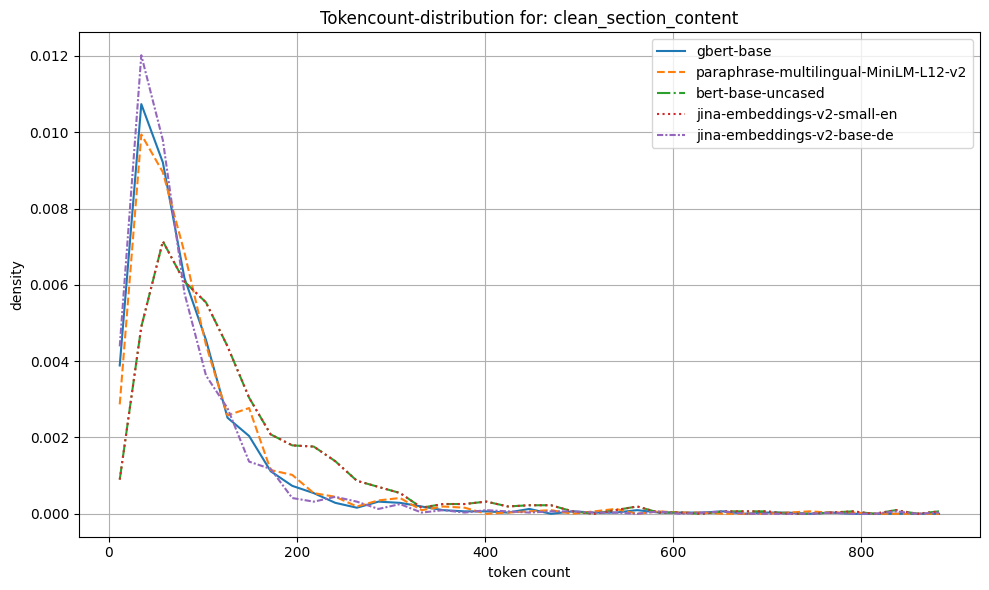

In [25]:

# Deine Spalte zum Analysieren
column = "clean_section_content"

# Modellnamen und URLs
model_names = [
    "gbert-base",
    "paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jina-embeddings-v2-small-en",
    "jina-embeddings-v2-base-de"
]

model_urls = [
    "deepset/gbert-base",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jinaai/jina-embeddings-v2-small-en",
    "jinaai/jina-embeddings-v2-base-de"
]

# Tokenizer vorbereiten
tokenizers = {}
for name, url in zip(model_names, model_urls):
    tokenizers[name] = AutoTokenizer.from_pretrained(url)

# Tokenlängen erfassen
token_counts = {}
for name, tokenizer in tokenizers.items():
    token_counts[name] = df_structured[column].fillna("").apply(lambda x: len(tokenizer.tokenize(x)))
print(token_counts)
# Plot: Verteilung der Tokenanzahl (99%-Quantil)
plt.figure(figsize=(10, 6))
max_x = max(token_counts[name].quantile(0.99) for name in token_counts)
bins = np.linspace(0, max_x, 40)

styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]

for (name, data), style in zip(token_counts.items(), styles):
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, hist, label=name, linestyle=style)

plt.title(f"Tokencount-distribution for: {column}")
plt.xlabel("token count")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 4.2 Model Assembly and Pooling start
In this section, we load a selection of transformer-based language models and prepare them for use with the Sentence Transformers framework. Each model is wrapped with a pooling strategy to generate fixed-size sentence embeddings.
Each model is assembled using the Sentence Transformers Transformer + Pooling modules. We store each configuration in a dictionary (models_dict) using a key that includes the model name and pooling strategy (e.g., base_gbert_sentence_cls).
If the RAM is not sufficient there is also the Option to safe all the build models for reuse without reloading from Hugging Face however when doing so they have to be excluded from the git repository since they are to big.
This setup provides a flexible and consistent framework to benchmark **15 different transformer** models and pooling strategies for downstream semantic matching tasks.


In [26]:
from sentence_transformers import SentenceTransformer, models
import os

models_in = [
    "deepset/gbert-base",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jinaai/jina-embeddings-v2-small-en",
    "jinaai/jina-embeddings-v2-base-de",
]

models_out = [
    "base_gbert_sentence",
    "multilingual_paraphrase_sentence",
    "bert_base_uncased_sentence",
    "jina_small_en_sentence",
    "jina_base_de_sentence",
]

pool_strats = ["cls", "mean", "max"]

# Dictionary zur Sammlung der Modelle
models_dict = {}
models_urls = {}
models_strat = {}


for model_in, model_out in zip(models_in, models_out):
    word_embedding_model = models.Transformer(model_in, max_seq_length=512)

    for pool_strat in pool_strats:
        print(f"Lade Modell: {model_out}, Strategie: {pool_strat}")

        cls = pool_strat == "cls"
        mean = pool_strat == "mean"
        maxi = pool_strat == "max"

        pooling_model = models.Pooling(
            word_embedding_model.get_word_embedding_dimension(),
            pooling_mode_cls_token=cls,
            pooling_mode_mean_tokens=mean,
            pooling_mode_max_tokens=maxi,
        )

        model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

        # Key z. B. "base_gbert_sentence_cls"
        dict_key = f"{model_out}_{pool_strat}"
        models_dict[dict_key] = model
        models_urls[dict_key] = model_in
        models_strat[dict_key] = pool_strat


        # Optional speichern:
        # model.save(f"../models/raw_STM/{dict_key}_emb")

# Ausgabe der geladenen Modelle
print("Geladene Modelle:", list(models_dict.keys()))


Some weights of the model checkpoint at deepset/gbert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Lade Modell: base_gbert_sentence, Strategie: cls
Lade Modell: base_gbert_sentence, Strategie: mean
Lade Modell: base_gbert_sentence, Strategie: max
Lade Modell: multilingual_paraphrase_sentence, Strategie: cls
Lade Modell: multilingual_paraphrase_sentence, Strategie: mean
Lade Modell: multilingual_paraphrase_sentence, Strategie: max


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Lade Modell: bert_base_uncased_sentence, Strategie: cls
Lade Modell: bert_base_uncased_sentence, Strategie: mean
Lade Modell: bert_base_uncased_sentence, Strategie: max


Some weights of the model checkpoint at jinaai/jina-embeddings-v2-small-en were not used when initializing BertModel: ['encoder.layer.1.mlp.gated_layers.weight', 'encoder.layer.1.mlp.wo.weight', 'encoder.layer.3.mlp.gated_layers.weight', 'encoder.layer.0.mlp.wo.weight', 'encoder.layer.3.mlp.layernorm.bias', 'encoder.layer.1.mlp.layernorm.bias', 'encoder.layer.1.mlp.wo.bias', 'encoder.layer.1.mlp.layernorm.weight', 'encoder.layer.2.mlp.layernorm.bias', 'encoder.layer.3.mlp.wo.weight', 'encoder.layer.0.mlp.wo.bias', 'encoder.layer.0.mlp.layernorm.bias', 'encoder.layer.2.mlp.wo.weight', 'encoder.layer.3.mlp.wo.bias', 'encoder.layer.2.mlp.layernorm.weight', 'encoder.layer.3.mlp.layernorm.weight', 'encoder.layer.0.mlp.gated_layers.weight', 'encoder.layer.2.mlp.gated_layers.weight', 'encoder.layer.0.mlp.layernorm.weight', 'encoder.layer.2.mlp.wo.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g

Lade Modell: jina_small_en_sentence, Strategie: cls
Lade Modell: jina_small_en_sentence, Strategie: mean
Lade Modell: jina_small_en_sentence, Strategie: max


Some weights of the model checkpoint at jinaai/jina-embeddings-v2-base-de were not used when initializing BertModel: ['encoder.layer.5.mlp.layernorm.weight', 'encoder.layer.1.mlp.gated_layers.weight', 'encoder.layer.1.mlp.wo.weight', 'encoder.layer.7.mlp.wo.bias', 'encoder.layer.9.mlp.layernorm.weight', 'encoder.layer.9.mlp.wo.bias', 'encoder.layer.10.mlp.layernorm.weight', 'encoder.layer.7.mlp.gated_layers.weight', 'encoder.layer.7.mlp.layernorm.weight', 'encoder.layer.10.mlp.wo.bias', 'encoder.layer.11.mlp.wo.bias', 'encoder.layer.3.mlp.gated_layers.weight', 'encoder.layer.0.mlp.wo.weight', 'encoder.layer.4.mlp.layernorm.bias', 'encoder.layer.3.mlp.layernorm.bias', 'encoder.layer.1.mlp.layernorm.bias', 'encoder.layer.1.mlp.wo.bias', 'encoder.layer.7.mlp.layernorm.bias', 'encoder.layer.5.mlp.layernorm.bias', 'encoder.layer.11.mlp.wo.weight', 'encoder.layer.1.mlp.layernorm.weight', 'encoder.layer.9.mlp.gated_layers.weight', 'encoder.layer.2.mlp.layernorm.bias', 'encoder.layer.3.mlp.wo.

Lade Modell: jina_base_de_sentence, Strategie: cls
Lade Modell: jina_base_de_sentence, Strategie: mean
Lade Modell: jina_base_de_sentence, Strategie: max
Geladene Modelle: ['base_gbert_sentence_cls', 'base_gbert_sentence_mean', 'base_gbert_sentence_max', 'multilingual_paraphrase_sentence_cls', 'multilingual_paraphrase_sentence_mean', 'multilingual_paraphrase_sentence_max', 'bert_base_uncased_sentence_cls', 'bert_base_uncased_sentence_mean', 'bert_base_uncased_sentence_max', 'jina_small_en_sentence_cls', 'jina_small_en_sentence_mean', 'jina_small_en_sentence_max', 'jina_base_de_sentence_cls', 'jina_base_de_sentence_mean', 'jina_base_de_sentence_max']


## 4.3 Matching Contract Sections to Catalog Entries Using Embeddings
In this section, we match contract sections to the most relevant catalog entries using vector-based semantic similarity. For each embedding model in our comparison, we perform the following steps:

Embedding Generation:
We encode the contract sections (clean_section_content) and the catalog examples (example) using the selected embedding model.

Similarity Computation:
We calculate the cosine similarity between each section embedding and all catalog entry embeddings. For each section, we select the catalog entry with the highest similarity score as the predicted match.

Ground Truth Comparison:
We compare the predicted catalog ID against the ground truth (true_catalog_id) to assess whether the top match is correct.

Evaluation with ROC Curve:
Using the cosine similarity scores as prediction confidence, we compute an ROC curve and the AUC (Area Under Curve) to measure how well the model distinguishes correct from incorrect matches.

Threshold Optimization:
We determine an optimal similarity threshold based on the ROC curve (max(TPR - 0.5 × FPR)), which we then use to classify matches as valid or invalid.

Postprocessing:
Matches below the threshold are marked as invalid by assigning a dummy catalog ID (-99), enabling further analysis and filtering.

This analysis is repeated for each model in our benchmark set. The results help us compare model performance and select the best embedding model for semantic contract section matching.

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
df_to_match = df_labeled[["contract","paragraph","section","clean_section_content"]]
df_true_match = df_labeled[["contract","paragraph","section","clean_section_content","catalog_id"]]
df_true_match.rename(columns={"catalog_id": "true_catalog_id"},inplace= True)
display(df_true_match)
df_true_match["true_catalog_id"] = df_true_match["true_catalog_id"].astype(int)
cols = ["contract","paragraph","section","clean_section_content"]

models_thresholds = {}
tab_contents = []
print(catalogue)

for model_name in models_dict:
    model_selected = models_dict[model_name]
    df_to_match = embed_text_column(df_to_match, text_column="clean_section_content",model = model_selected, target_column=f"section_em_{model_name}" )
    cat = embed_text_column(catalogue, text_column = "example", model = model_selected, target_column = "emb")
    cols.append(f"section_em_{model_name}")
    df_to_match  = df_to_match[cols]
    X = np.vstack(df_to_match[f"section_em_{model_name}" ].values)  # Shape: [1400, 768]
    Y = np.vstack(cat["emb"].values)                  # Shape: [100, 768]

    # Cosine Similarity: alle Kombinationen
    similarity_matrix = cosine_similarity(X, Y)  # Shape: [1400, 100]
    similarity_percent = np.round(similarity_matrix * 100, 2)  # Skaliert zu 0–100 %

    best_match_idx = similarity_matrix.argmax(axis=1)
    best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

    # Ergebnisse anhängen
    df_to_match[f"matched_example_index_{model_name}"] = best_match_idx
    df_to_match[f"similarity_percent_{model_name}"] = best_match_score
    df_to_match[f"matched_example_text_{model_name}"] = cat.loc[best_match_idx, "example"].values
    df_to_match[f"matched_example_topic_{model_name}"] = cat.loc[best_match_idx, "section_topic"].values
    df_to_match[f"matched_paragraph_{model_name}"] = cat.loc[best_match_idx, "paragraph_topic"].values
    df_to_match[f"matched_catalog_id_{model_name}"] = cat.loc[best_match_idx, "catalog_id"].values

    # # print(df_true_match["true_catalog_id"].dtype)
    # print(df_to_match[f"matched_catalog_id_{model_name}"].dtype)    
    

    y_true = (df_true_match["true_catalog_id"].values == df_to_match[f"matched_catalog_id_{model_name}"].values).astype(int)
    y_scores = df_to_match[f"similarity_percent_{model_name}"].values / 100  # zurück zu 0–1
    # print("Verteilung der Klassen in y_true:")
    # print(np.unique(y_true, return_counts=True))


    # ROC-Kurve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    custom_score = tpr - 0.5 * fpr
    optimal_idx = np.argmax(custom_score)
    optimal_threshold = thresholds[optimal_idx]
    
    output = widgets.Output()
    with output:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label='Optimal Threshold')
        plt.legend(loc='lower right')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

        tab_contents.append((title, output))
    # Optimaler Threshold = max(tpr - fpr)

    # print(f"Optimaler Threshold für Cosine Similarity (%): {optimal_threshold * 100:.2f}")
    # Neue Spalte: Match nur wenn Score >= Threshold
    df_to_match[f"match_valid_{model_name}"] = y_scores >= optimal_threshold
    df_to_match.loc[~df_to_match[f"match_valid_{model_name}"], f"matched_catalog_id_{model_name}"] = -99
    cols = list(df_to_match.columns)
    # display(df_to_match)
    models_thresholds[model_name] = optimal_threshold

tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)
    







display(tab_widget)


,contract,paragraph,section,clean_section_content,true_catalog_id
0,2,§ 7,(1),zahlungszeitraum und höhe der richten sich ebe...,1
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,69
2,4,3.,3.2,support und sla sap erbringt support für den c...,31
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,8
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,70
...,...,...,...,...,...
59,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,68
60,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,57
61,26,17.,17.3,pflichten von sellers sellers unterstützt den ...,58
62,26,17.,17.6,datenlöschung nach vollzug des wechsels seller...,59


                          paragraph_topic  \
0   Projektkosten_und_Zahlungsmodalitäten   
1   Projektkosten_und_Zahlungsmodalitäten   
2   Projektkosten_und_Zahlungsmodalitäten   
3   Projektkosten_und_Zahlungsmodalitäten   
4   Projektkosten_und_Zahlungsmodalitäten   
..                                    ...   
71             Sonstige_wichtige_Klauseln   
72             Sonstige_wichtige_Klauseln   
73             Sonstige_wichtige_Klauseln   
74             Sonstige_wichtige_Klauseln   
75             Sonstige_wichtige_Klauseln   

                                        section_topic  \
0   Sind sämtliche Kostenarten und -bestandteile (...   
1   Ist das Vergütungsmodell eindeutig festgelegt ...   
2   Ist ein Zahlungsplan mit konkreten Fälligkeite...   
3   Sind Währung, Rechnungsstellung, Zahlungsfrist...   
4   Regelt der Vertrag den Umgang mit Nebenkosten ...   
..                                                ...   
71  Ist die anwendbare Rechtsordnung eindeutig ver...   
72 

Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  6.60it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


Embedding example: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.57it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.75it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]
/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_8714/3035876879.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_to_match[f"matched_example_index_{model_name}"] = best_match_idx
/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_8714/3035876879.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_to_match[f"similarity_percent_{model_name}"] = best_match_score
/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_8714/3035876879.py:

/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_8714/3035876879.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_to_match[f"match_valid_{model_name}"] = y_scores >= optimal_threshold
Embedding clean_section_content: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]
/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_8714/1714337458.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[target_column] = all_embeddings
Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]
/var/folders/n9/9rvxcg4d1d

/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_8714/3035876879.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_to_match[f"match_valid_{model_name}"] = y_scores >= optimal_threshold
Embedding clean_section_content: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]
/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_8714/1714337458.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[target_column] = all_embeddings
Embedding example: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]
/var/folders/n9/9rvxcg4d1d

/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_8714/3035876879.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_to_match[f"match_valid_{model_name}"] = y_scores >= optimal_threshold


In [28]:
df_matched = df_to_match
from sklearn.metrics import accuracy_score, f1_score, classification_report

results = []

for model_name in models_dict:
    print(f"### {model_name} ###")
    df_matched_ids = df_matched[["contract","paragraph","section","clean_section_content",f"matched_catalog_id_{model_name}"]]
    print("Accuracy:", accuracy_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"]))
    print("F1 (macro):", f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='macro'))
    print("F1 (weighted):", f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='weighted'))
    print("\nReport:\n", classification_report(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"]))

    print(f"### {model_name} ###")

    results.append({
            "model": model_name,
            "recall (macro)": recall_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='macro'),
            "recall (weighted)": recall_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='weighted'),
            "Accuracy": accuracy_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"]),
            "F1 (macro)": f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='macro'),
            "F1 (weighted)": f1_score(df_true_match["true_catalog_id"], df_matched_ids[f"matched_catalog_id_{model_name}"], average='weighted')
        })

### base_gbert_sentence_cls ###
Accuracy: 0.140625
F1 (macro): 0.09436274509803921
F1 (weighted): 0.10026041666666667

Report:
               precision    recall  f1-score   support

         -99       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.50      1.00      0.67         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
       

/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classific

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import ipywidgets as widgets
from IPython.display import display

tab_contents = []

for model_name in models_dict:
    output = widgets.Output()
    with output:
        # Daten vorbereiten
        df_matched_ids = df_matched[["contract", "paragraph", "section", "clean_section_content", f"matched_catalog_id_{model_name}"]]
        y_true = df_true_match["true_catalog_id"].astype(str)
        y_pred = df_matched_ids[f"matched_catalog_id_{model_name}"].astype(str)

        # Alle Labels für Achsen
        all_labels = sorted(set(y_true.unique()).union(set(y_pred.unique())))
        cm = confusion_matrix(y_true, y_pred, labels=all_labels)

        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                    xticklabels=all_labels, 
                    yticklabels=all_labels)
        plt.title(f"Confusion Matrix: {model_name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()
    
    tab_contents.append((model_name, output))

# Tabs erzeugen
tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)

display(tab_widget)


In [30]:
results_df = pd.DataFrame(results).sort_values("recall (weighted)", ascending=False)
thresholds_df = pd.DataFrame(models_thresholds.items(), columns=["model", "optimal_threshold"])
models_urls_df = pd.DataFrame(models_urls.items(), columns=["model", "model_url"])
models_strat_df = pd.DataFrame(models_strat.items(), columns=["model", "pooling_strategy"])
results_df = results_df.merge(models_urls_df, on="model", how="left").merge(models_strat_df, on="model", how="left").merge(thresholds_df, on="model", how="left")
display(results_df)
results_df.to_csv("../data/results.csv", index=False)


,model,recall (macro),recall (weighted),Accuracy,F1 (macro),F1 (weighted),model_url,pooling_strategy,optimal_threshold
0,multilingual_paraphrase_sentence_mean,0.353846,0.375000,0.375000,0.299487,0.325000,sentence-transformers/paraphrase-multilingual-...,mean,0.5818
1,multilingual_paraphrase_sentence_max,0.235294,0.265625,0.265625,0.192437,0.225298,sentence-transformers/paraphrase-multilingual-...,max,0.8587
2,base_gbert_sentence_mean,0.224638,0.250000,0.250000,0.187716,0.212798,deepset/gbert-base,mean,0.7840
3,multilingual_paraphrase_sentence_cls,0.171875,0.187500,0.187500,0.153646,0.169271,sentence-transformers/paraphrase-multilingual-...,cls,0.8052
4,base_gbert_sentence_max,0.161765,0.171875,0.171875,0.133333,0.141667,deepset/gbert-base,max,0.9375
5,bert_base_uncased_sentence_max,0.146154,0.171875,0.171875,0.123528,0.151500,bert-base-uncased,max,0.9713
6,base_gbert_sentence_cls,0.132353,0.140625,0.140625,0.094363,0.100260,deepset/gbert-base,cls,0.8312
7,jina_small_en_sentence_cls,0.119403,0.140625,0.140625,0.119403,0.145833,jinaai/jina-embeddings-v2-small-en,cls,0.9052
8,bert_base_uncased_sentence_mean,0.100000,0.109375,0.109375,0.084615,0.096354,bert-base-uncased,mean,0.9740
9,jina_small_en_sentence_max,0.088235,0.109375,0.109375,0.088235,0.109375,jinaai/jina-embeddings-v2-small-en,max,0.9204


# 5. Finetuning

In [31]:
results_df = pd.read_csv("../data/results.csv")
best_model = results_df[["model","model_url","pooling_strategy","optimal_threshold"]].iloc[0]
print(best_model)

df_unlabeled = pd.read_pickle("../data/data_clean.pkl")
df_unlabeled = df_unlabeled[["contract","paragraph","section","section_content","clean_section_content"]]
display(df_unlabeled)


mapping = pd.read_excel("../data/mapping_human.xlsx")
mapping = mapping[["section_content","catalog_id"]]
display(mapping)

df_labeled = mapping.merge(df_unlabeled, how = "left", on = "section_content")
df_labeled= df_labeled[["contract","paragraph","section","clean_section_content","catalog_id"]]
df_labeled = df_labeled[df_labeled["catalog_id"].notna()]


print(df_labeled.head)


catalogue = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue = catalogue.rename(columns={'example': 'clean_section_content'})
catalogue = catalogue[['clean_section_content']]
catalogue["catalog_id"] = range(len(catalogue))






model                            multilingual_paraphrase_sentence_mean
model_url            sentence-transformers/paraphrase-multilingual-...
pooling_strategy                                                  mean
optimal_threshold                                               0.5818
Name: 0, dtype: object


,contract,paragraph,section,section_content,clean_section_content
0,1,§ 1,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...,der anbieter stellt dem kunden die software na...
1,1,§ 1,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...,die nutzung umfasst die bereitstellung von fun...
2,1,§ 1,1.3,1.3 Der Kunde erhält ausschließlich das vertra...,der kunde erhält ausschließlich das vertraglic...
3,2,§ 1,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...,dieser software as a service vertrag ist auf o...
4,2,§ 1,(2),(2) Die Software wird vom Anbieter als webbasi...,die software wird vom anbieter als webbasierte...
...,...,...,...,...,...
1371,26,19.,19.2,"19.2 Anhänge sind in ihrer jeweils gültigen, d...",anhänge sind in ihrer jeweils gültigen d h von...
1372,26,19.,19.3,19.3 Nebenbestimmungen außerhalb dieses Vertra...,nebenbestimmungen außerhalb dieses vertrags un...
1373,26,19.,19.4,19.4 Die etwaige Unwirksamkeit einzelner Besti...,die etwaige unwirksamkeit einzelner bestimmung...
1374,26,19.,19.5,19.5 Ergeben sich in der praktischen Infrastru...,ergeben sich in der praktischen infrastruktur ...


,section_content,catalog_id
0,(1) Zahlungszeitraum und Höhe der Vergütung ri...,1
1,(2) Die außerordentliche Kündigung aus wichtig...,69
2,3.2. Support und SLA 3.2.1. SAP erbringt Suppo...,31
3,5.2. Alle Vergütungen unterliegen den jeweils ...,8
4,6.3. Im Falle einer Kündigung des Auftraggeber...,70
...,...,...
59,16.1 Das Vertragsverhältnis beginnt mit dem Zu...,68
60,17.1 Vorzeitige Beendigung des Vertrages wegen...,57
61,17.3 Pflichten von 4SELLERS 4SELLERS unterstüt...,58
62,17.6 Datenlöschung nach Vollzug des Wechsels 4...,59


<bound method NDFrame.head of     contract paragraph section  \
0        NaN       NaN     NaN   
1        2.0      § 12     (2)   
2        4.0        3.     3.2   
3        4.0        5.     5.2   
4        4.0        6.     6.3   
..       ...       ...     ...   
68      26.0       16.    16.1   
69      26.0       17.    17.1   
70      26.0       17.    17.3   
71      26.0       17.    17.6   
72       NaN       NaN     NaN   

                                clean_section_content  catalog_id  
0                                                 NaN           1  
1   die außerordentliche kündigung aus wichtigem g...          69  
2   support und sla sap erbringt support für den c...          31  
3   alle vergütungen unterliegen den jeweils anwen...           8  
4   im falle einer kündigung des auftraggebers ode...          70  
..                                                ...         ...  
68  das vertragsverhältnis beginnt mit dem zugang ...          68  
69  vorzeitige be

In [32]:
import inspect
from sentence_transformers.models import Pooling
print("Model Summary:")
print("#####################################################")
print("# # # # # # # # # # # # # # # # # # # # # # # # # # #")
print("#####################################################")
print(f'Model: {best_model["model"]}') 
print("------------------------------------------------------------")
print(f' embeddings from: {best_model["model_url"]}: ')
print(models_dict[best_model["model"]][0].auto_model)
print("#####################################################")
print(f' pooling strategy: {best_model["pooling_strategy"]}')
print("------------------------------------------------------------")
print(models_dict[best_model["model"]][1])  
print(inspect.getsource(Pooling.forward))
print("#####################################################")
print(f' classification threashold: {best_model["optimal_threshold"]}')
print("------------------------------------------------------------")


Model Summary:
#####################################################
# # # # # # # # # # # # # # # # # # # # # # # # # # #
#####################################################
Model: multilingual_paraphrase_sentence_mean
------------------------------------------------------------
 embeddings from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2: 
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(250037, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value)

In [33]:
pool_strat = best_model["pooling_strategy"]
word_embedding_model = models_dict[best_model["model"]][0]

print(
    pool_strat
)

cls = pool_strat == "cls"
mean = pool_strat == "mean"
maxim = pool_strat == "max"

pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_cls_token=cls,
    pooling_mode_mean_tokens=mean,
    pooling_mode_max_tokens=maxim,
)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


print(catalogue["clean_section_content"])
catalogue_emb = embed_text_column(catalogue, text_column="clean_section_content", model=model, target_column="emb")
print(catalogue["emb"])
label_embeddings = torch.tensor(np.stack(catalogue["emb"].to_list())).float()


mean
0     im festpreis von € sind sämtliche leistungen e...
1     der kunde zahlt eine monatliche pauschale von ...
2     die vergütung ist in drei raten zahlbar bei pr...
3     alle preise verstehen sich in euro zuzüglich g...
4     reise und übernachtungskosten werden nur ersta...
                            ...                        
71    dieser vertrag unterliegt dem recht der bundes...
72    gerichtsstand für alle streitigkeiten aus oder...
73    dieser vertrag wird in deutscher und englische...
74    sollte eine bestimmung dieses vertrages unwirk...
75    keine der parteien haftet für die nichterfüllu...
Name: clean_section_content, Length: 76, dtype: object


Embedding clean_section_content: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]

0     [-0.043492995, -0.049756475, -0.16985616, -0.0...
1     [0.043275297, -0.07633343, -0.18871349, -0.186...
2     [-0.021282071, 0.08918063, -0.074413195, -0.15...
3     [-0.027547942, 0.26793677, -0.37035942, -0.034...
4     [-0.00419344, 0.08625529, -0.14960864, 0.06756...
                            ...                        
71    [-0.10875682, 0.2565331, -0.28214228, 0.000559...
72    [-0.09892851, 0.4876701, -0.35838556, -0.13141...
73    [0.0712586, 0.293805, -0.15235408, -0.06150583...
74    [-0.06851821, 0.092890464, -0.23958045, -0.043...
75    [-0.02261513, -0.012663827, -0.07828589, 0.065...
Name: emb, Length: 76, dtype: object


In [34]:
class MultilingualParaphraseCosineClassifier(nn.Module):
    def __init__(
        self,
        model_name= best_model["model_url"],
        label_embeddings = label_embeddings,
        pooling= best_model["pooling_strategy"],
        threshold= best_model["optimal_threshold"]
    ):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        config = AutoConfig.from_pretrained(model_name)
        self.bert = AutoModel.from_pretrained(model_name,config = config)  # Verwende 'gelu' als Aktivierungsfunktion
        self.pooling = pooling
        self.threshold = threshold

        self.label_embeddings = nn.Parameter(label_embeddings, requires_grad=False)  # z. B. aus SentenceTransformer
        self.activation = nn.GELU()  # Verwende 'gelu' als Aktivierungsfunktion

        self.dropout = nn.Dropout(0.5)

    def forward(self, texts,return_embedding = False  ):
        if isinstance(texts, str):
            texts = [texts]

        inputs = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        outputs = self.bert(**inputs)
        token_embeddings = outputs.last_hidden_state  # (B, T, H)

        # Pooling
        if self.pooling == "cls":
            pooled = token_embeddings[:, 0]
        elif self.pooling == "max":
            mask = inputs["attention_mask"].unsqueeze(-1).expand(token_embeddings.shape).float()
            token_embeddings[mask == 0] = -1e9
            pooled = torch.max(token_embeddings, dim=1)[0]
        elif self.pooling == "mean":
            mask = inputs["attention_mask"].unsqueeze(-1).expand(token_embeddings.shape).float()
            summed = torch.sum(token_embeddings * mask, dim=1)
            counts = mask.sum(dim=1).clamp(min=1e-9)
            pooled = summed / counts
        else:
            raise ValueError("Unknown pooling method")

        pooled = self.dropout(pooled)
        if return_embedding:
            return pooled 

        # Cosine similarity zu allen Labels
        normalized_input = nn.functional.normalize(pooled, dim=1)
        normalized_labels = nn.functional.normalize(self.label_embeddings, dim=1)

        cosine_sim = torch.matmul(normalized_input, normalized_labels.T)  # (B, num_labels)
        return cosine_sim

    def predict(self, texts, top_k: int = 1, return_scores: bool = False):
        with torch.no_grad():
            scores = self.forward(texts)

        if return_scores:
            # Gib Top-k Indizes (+1) und Scores zurück
            topk_scores, topk_indices = torch.topk(scores, k=top_k, dim=1)
            results = []
            for indices, values in zip(topk_indices, topk_scores):
                results.append([(i.item(), round(s.item(), 4)) for i, s in zip(indices, values)])
            return results if len(results) > 1 else results[0]

        else:
            # Gib nur Index (+1) der besten Klasse zurück
            preds = torch.argmax(scores, dim=1)
            result = (preds+1 ).tolist()
            return result[0] if len(result) == 1 else result


In [35]:
model = MultilingualParaphraseCosineClassifier(
    model_name=best_model["model_url"],
    label_embeddings=label_embeddings,
    pooling=best_model["pooling_strategy"],
    threshold=best_model["optimal_threshold"],
)
model


MultilingualParaphraseCosineClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), 

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# 1. Alle Texte und true labels holen
texts = df_labeled["clean_section_content"].tolist()
texts = [str(t) if not isinstance(t, str) else t for t in texts]

true_labels = df_labeled["catalog_id"].tolist()  # oder wie deine Label-Spalte heißt
# 2. Vorhersagen holen
model.return_scores = False  # wichtig: keine Scores, sondern Predictions
pred_labels = model.predict(texts)  # gibt List[int]

# 3. Klassifikationsbericht
print(classification_report(true_labels, pred_labels, digits=3))



              precision    recall  f1-score   support

           1      0.000     0.000     0.000         1
           2      1.000     1.000     1.000         1
           3      0.000     0.000     0.000         1
           4      1.000     1.000     1.000         1
           5      0.000     0.000     0.000         1
           6      0.000     0.000     0.000         1
           8      1.000     1.000     1.000         1
           9      0.000     0.000     0.000         2
          11      0.000     0.000     0.000         0
          12      0.000     0.000     0.000         1
          13      0.000     0.000     0.000         1
          14      0.000     0.000     0.000         1
          15      0.000     0.000     0.000         1
          16      0.000     0.000     0.000         1
          19      0.333     0.500     0.400         2
          20      0.000     0.000     0.000         0
          21      1.000     0.500     0.667         2
          22      0.000    

/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/utils/multiclass.p

In [37]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


In [38]:

# Nur Zeilen behalten, bei denen "clean_section_content" nicht NaN ist
filtered_df = df_labeled.dropna(subset=["clean_section_content"])

# Labels (int) extrahieren
filtered_df["label"] = filtered_df["catalog_id"].astype(int)

# Listen erzeugen
texts = filtered_df["clean_section_content"].tolist()
labels = filtered_df["label"].tolist()


# Split in Train/Test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.3,  random_state=42
)

test_texts, val_texts, test_labels, val_labels = train_test_split(
    val_texts,
    val_labels,
    test_size=0.5,
    random_state=42
)


class TextLabelDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "text": self.texts[idx],
            "label": self.labels[idx]
        }
train_dataset = TextLabelDataset(train_texts, train_labels)
val_dataset = TextLabelDataset(val_texts, val_labels)
test_dataset = TextLabelDataset(test_texts, test_labels)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False
)

for batch in train_loader:
    print(batch["text"][0])
    print(batch["label"][0])
    break

das vertragsverhältnis beginnt mit dem zugang der mitteilung von sellers an den kunden in textform oder über das ticketsystem dass die auf seiten des rechenzentrums durchzuführenden leistungen technisch abgeschlossen sind spätestens aber mit dem ersten des auf den zugang der mitteilung folgenden monats unterbliebene mitwirkungsleistungen des kunden verhindern nicht den beginn der laufzeit der vertrag hat eine mindestvertragslaufzeit bis zum des auf den vertragsbeginn folgenden jahres und verlängert sich automatisch um jeweils weitere monate wenn er nicht von einer der parteien schriftlich mit einer frist von monaten zum ende eines kalenderjahres ordentlich gekündigt wird
tensor(68)


/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_8714/3301548326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["label"] = filtered_df["catalog_id"].astype(int)


In [39]:
epochs = 100  #number of epochs i.e. how many times is the whole dataset passed through the architecture
patience = 5  # Number of epochs to wait before stopping if no improvement
best_val_loss = float("inf")
patience_counter = 0
optim = AdamW(model.parameters(), lr=5e-5) 
model.train()  # Set model to training mode

MultilingualParaphraseCosineClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), 

In [40]:
train_losses = []
val_losses = []
criterion = nn.CrossEntropyLoss()
best_val_loss = float("inf")
patience = 10
patience_counter = 0
model.return_scores=True
print(model("test"))

for epoch in range(epochs):
    model.train()
    train_total_loss = 0

    for batch in train_loader:
        texts = batch["text"]
        labels = batch["label"]
        print(texts)
        optim.zero_grad()

        logits = model(texts)  # cosine similarity (B, num_labels)
        loss = criterion(logits, labels)

        train_total_loss += loss.item()
        loss.backward()
        optim.step()

    avg_train_loss = train_total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            texts = batch["text"]
            labels = batch["label"]

            logits = model(texts)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_val_preds.extend(preds.cpu().tolist())
            all_val_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# Nach dem Training: bestes Modell laden
model.load_state_dict(torch.load("best_model.pth"))
model.eval() #so sieht der aktuelle output aus 

tensor([[-4.2898e-03, -4.8557e-02,  1.8521e-01,  2.1263e-02,  8.3455e-05,
          6.1196e-02,  4.5280e-02,  1.2980e-01,  1.0052e-01, -9.3703e-02,
          5.1490e-02, -5.0138e-02, -4.7574e-02,  7.1662e-02,  1.4439e-02,
          1.6274e-01,  2.3881e-01,  1.0133e-01,  5.6088e-02,  4.7657e-02,
          1.4508e-01,  3.3368e-01,  2.4456e-01,  6.2797e-02,  5.2928e-02,
          5.7609e-02,  1.0186e-01, -7.2550e-02,  1.3051e-01,  1.5009e-02,
          1.4744e-01, -4.4500e-02, -2.1956e-02,  4.0832e-02, -6.8214e-02,
         -3.9484e-02, -9.9950e-02, -1.3359e-02, -4.8781e-02, -9.1783e-02,
          8.5457e-02, -7.1988e-02,  1.2188e-02,  2.9962e-02, -1.9379e-02,
         -4.6925e-02, -3.5945e-02, -1.0932e-02, -7.8028e-02, -1.0345e-02,
          1.3088e-01,  1.9171e-02,  9.1207e-02,  8.0305e-02,  8.8102e-02,
          6.5121e-02, -4.4386e-02,  5.9785e-03,  9.8004e-02, -1.4095e-02,
          2.4726e-02, -4.6299e-02,  2.1150e-02,  1.8492e-01,  1.4823e-01,
          3.0234e-02,  8.0974e-02,  3.

MultilingualParaphraseCosineClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), 

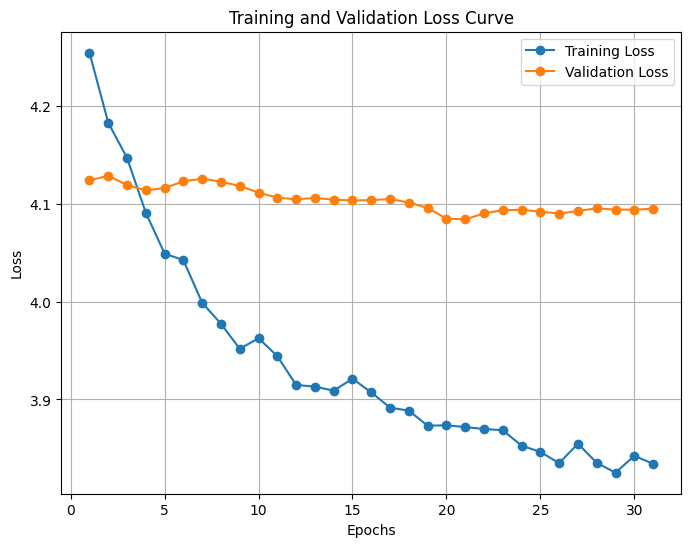

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Ohne TEST 

In [42]:
from torch.utils.data import Dataset


# Nur Zeilen behalten, bei denen "clean_section_content" nicht NaN ist
filtered_df = df_labeled.dropna(subset=["clean_section_content"])

# Labels (int) extrahieren
filtered_df["label"] = filtered_df["catalog_id"].astype(int)

# Listen erzeugen
texts = filtered_df["clean_section_content"].tolist()
labels = filtered_df["label"].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2,  random_state=42
)


class TextLabelDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "text": self.texts[idx],
            "label": self.labels[idx]
        }
train_dataset = TextLabelDataset(train_texts, train_labels)
val_dataset = TextLabelDataset(val_texts, val_labels)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False
)



/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_8714/204580612.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["label"] = filtered_df["catalog_id"].astype(int)


In [43]:
epochs = 1000  #number of epochs i.e. how many times is the whole dataset passed through the architecture
patience = 10  # Number of epochs to wait before stopping if no improvement
best_val_loss = float("inf")
patience_counter = 0
model = MultilingualParaphraseCosineClassifier(
    model_name=best_model["model_url"],
    label_embeddings=label_embeddings,      
    pooling=best_model["pooling_strategy"],
    threshold=best_model["optimal_threshold"]
)
optim = AdamW(model.parameters(), lr=100e-6)    

model.train()  # Set model to training mode

MultilingualParaphraseCosineClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), 

In [44]:
print("Shape of label_embeddings:", label_embeddings.shape) 
train_losses = []
val_losses = []
criterion = nn.CrossEntropyLoss()
best_val_loss = float("inf")
patience = 10
patience_counter = 0
model.return_scores=True
print(model("test"))

for epoch in range(epochs):
    model.train()
    train_total_loss = 0

    for batch in train_loader:
        texts = batch["text"]
        labels = batch["label"]

        optim.zero_grad()

        logits = model(texts)  # cosine similarity (B, num_labels)
        loss = criterion(logits, labels)

        train_total_loss += loss.item()
        loss.backward()
        optim.step()

    avg_train_loss = train_total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            texts = batch["text"]
            labels = batch["label"]

            logits = model(texts)
            loss = criterion(logits, labels)
            val_loss += loss.item()

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_val_preds.extend(preds.cpu().tolist())
            all_val_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_no_test.pth")
        print("✅ Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break
        


Shape of label_embeddings: torch.Size([76, 384])
tensor([[ 0.0601, -0.0306,  0.2146, -0.0111,  0.0614,  0.0479, -0.0062,  0.0969,
          0.1215, -0.0557,  0.0599, -0.0572,  0.0495,  0.0794,  0.0431,  0.1705,
          0.2511,  0.0528,  0.0088,  0.1143,  0.1874,  0.3652,  0.2801,  0.0605,
          0.0051,  0.0801,  0.0601, -0.1053,  0.1377,  0.0186,  0.1069, -0.0156,
          0.0150,  0.0491, -0.0372, -0.0151, -0.0488,  0.0605, -0.0360, -0.0327,
          0.1084, -0.0294,  0.0191,  0.0215,  0.0267, -0.0142,  0.0101,  0.0301,
         -0.0724,  0.0593,  0.1521, -0.0159,  0.0692,  0.0428,  0.0986,  0.0464,
         -0.0660, -0.0672,  0.0785, -0.0034, -0.0311,  0.0047,  0.0620,  0.1522,
          0.1020, -0.0285,  0.0062,  0.0007,  0.0940,  0.0060,  0.0363, -0.0511,
          0.0246,  0.0120,  0.0342, -0.0756]], grad_fn=<MmBackward0>)
Epoch 1, Training Loss: 4.2474
Epoch 1, Validation Loss: 4.1848
✅ Model saved!
Epoch 2, Training Loss: 4.1406
Epoch 2, Validation Loss: 4.1860
Epoch 3, 

In [45]:

# Nach dem Training: bestes Modell laden
model.load_state_dict(torch.load("best_model.pth"))
model.eval() #so sieht der aktuelle output aus 

MultilingualParaphraseCosineClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), 

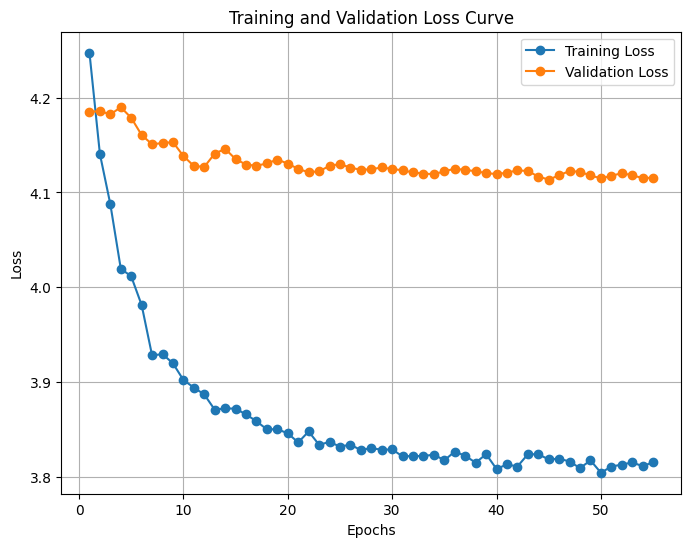

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

# 6. Application + Textual checking of requirements 

In [47]:
df_labeled = df_labeled[pd.notna(df_labeled["contract"])]
contracts_with_labels = df_labeled["contract"].astype(int).unique()
np.append(contracts_with_labels, 1)

print(contracts_with_labels)


contracts= pd.read_pickle("../data/data_scraped_input_relevant.pkl")
contracts["contract"] = contracts["contract"].astype(int)
contracts_without_labels = contracts[~contracts["contract"].isin(contracts_with_labels)]["contract"].unique().tolist()
random_contract = random.choice(contracts_without_labels)
exp = contracts[contracts["contract"] == random_contract]  # Beispiel: zufällige 1 Verträge
print(exp)

[ 2  4  5  6  7  8 11 12 13 14 20 18 19 21 22 23 24 26]
    contract                                            content
19        15  Allgemeine Geschäftsbedingungen\nSoftware as a...


In [48]:



class SectionTopicPredictor:
    def __init__(self, model, catalogue_clean):
        """
        Parameters:
        - model: dein MultilingualParaphraseCosineClassifier mit predict()-Methode
        - catalogue_clean: DataFrame mit Spalte 'section_topic'
        """
        self.model = model
        self.catalogue_clean = catalogue_clean

    def _preprocess_contract(self, text):
        """
        Führt Paragraph- und Abschnittsextraktion + Cleaning durch.
        """
        fake_row = {"content": text, "contract": 1}
        sections = extract_paragraphs_and_sections(fake_row)  # -> List[Dict]
        for section in sections:
            section["clean_section_content"] = clean_contract_text(section["section_content"])
        return sections

    def predict_contract(self, contract_text, return_topic_score=False):
        """
        contract_text: Volltext eines Vertrags (String)

        Rückgabe: DataFrame mit Feldern aus den extrahierten Sections + 'predicted_topic'
        """
        cont_exp = self._preprocess_contract(contract_text)
        return self.predict_sections(cont_exp, return_topic_score=return_topic_score)

    def predict_sections(self, cont_exp, return_topic_score=False):
        """
        cont_exp: Liste von Dicts mit mindestens 'section', 'section_content', 'clean_section_content'

        Rückgabe: DataFrame mit allen ursprünglichen Feldern + 'predicted_topic'
        """
        records = []

        for section in cont_exp:
            cleaned = section['clean_section_content']

            if return_topic_score:
                model_output = self.model.predict(cleaned, return_scores=True)

                top = max(model_output, key=lambda x: x[1])
                label = top[0]
                score = top[1]
                index = int(label) - 1 
            else:
                label = self.model.predict(cleaned, return_scores=False)
                index = int(label) - 1
                score = None

            topic = self.catalogue_clean["section_topic"].iloc[index]

            record = {**section, "predicted_topic": topic}
            if return_topic_score:
                record["score"] = score

            records.append(record)

        return pd.DataFrame(records)
    


In [49]:

top_scores = []
top_sections = []
print(catalogue_clean)
print(exp["content"])

for i in contracts_without_labels:

    exp = contracts[contracts["contract"] == i] 
    predictor = SectionTopicPredictor(model, catalogue_clean)
    result_df = predictor.predict_contract(exp["content"].values[0], return_topic_score=True)

    # Ausgabe (optional)
    print(result_df.sort_values("score", ascending=False).head(1))
    sorted_df = result_df.sort_values("score", ascending=False)

    top_score = sorted_df.iloc[0]["score"]
    top_section = sorted_df.iloc[0]["section"]
    top_scores.append(top_score)  
    top_sections.append(top_section)  



                          paragraph_topic  \
0   Projektkosten_und_Zahlungsmodalitäten   
1   Projektkosten_und_Zahlungsmodalitäten   
2   Projektkosten_und_Zahlungsmodalitäten   
3   Projektkosten_und_Zahlungsmodalitäten   
4   Projektkosten_und_Zahlungsmodalitäten   
..                                    ...   
71             Sonstige_wichtige_Klauseln   
72             Sonstige_wichtige_Klauseln   
73             Sonstige_wichtige_Klauseln   
74             Sonstige_wichtige_Klauseln   
75             Sonstige_wichtige_Klauseln   

                                        section_topic  \
0   Sind sämtliche Kostenarten und -bestandteile (...   
1   Ist das Vergütungsmodell eindeutig festgelegt ...   
2   Ist ein Zahlungsplan mit konkreten Fälligkeite...   
3   Sind Währung, Rechnungsstellung, Zahlungsfrist...   
4   Regelt der Vertrag den Umgang mit Nebenkosten ...   
..                                                ...   
71  Ist die anwendbare Rechtsordnung eindeutig ver...   
72 

In [50]:
print(top_scores)
top_sections

[0.5769, 0.5122, 0.5103, 0.4465, 0.6676, 0.7855, 0.6064, 0.7521]


['1.2', '2.2', '1.3', '(1)', '4.4', '14.2', 'no sections use paragraph', '(3)']

In [51]:
exp = contracts[contracts["contract"] == 26] 
for i in range(len(exp)):  
    text = exp["content"].values[0]
    predicted_df = predictor.predict_contract(text, return_topic_score=True)
    #print(predicted_df)

# Gute Kombi z.b contract 26 section 73
random_index = random.randint(0, len(predicted_df) - 1)

topic = predicted_df.loc[random_index, "predicted_topic"]
content = predicted_df.loc[random_index, "section_content"]
score = predicted_df.loc[random_index, "score"]

print("🔹 Predicted Topic:\n", topic)
print("\n🔸 Section Content:\n", content)
# Print Section Content in green color
print("\033[92m🔥 Score:\033[0m", score)



🔹 Predicted Topic:
 Regelt der Vertrag den Umgang mit Nebenkosten (z.B. Reise-/Spesen) und zusätzlichen Leistungen außerhalb des Vertragsumfangs?

🔸 Section Content:
 16.3 Ungeachtet der Regelung in Abs. 2 kann 4SELLERS den Vertrag ohne Einhaltung einer Frist kündigen, wenn der Kunde für zwei aufeinander folgende Monate mit der Bezahlung der Preise bzw. eines nicht unerheblichen Teils der Preise oder in einem Zeitraum, der sich über mehr als zwei Monate erstreckt, mit der Bezahlung des Entgelts in Höhe eines Betrags, der das Entgelt für zwei Monate erreicht, in Verzug ist. 4SELLERS hat in diesem Fall die Wahl, zusätzlich einen sofort in einer Summe fälligen pauschalierten Schadensersatz in Höhe eines Viertels der bis zum Ablauf der regulären Vertragslaufzeit restlichen monatlichen Grundpauschale verlangen oder den konkreten Schaden bis zum Ablauf der Vertragslaufzeit zu verlangen. Dem Kunden bleibt der Nachweis eines geringeren Schadens vorbehalten.
🔥 Score: 0.5871


In [52]:
#Functioniert gut Vertrag 26 index 68
random_index

68

In [53]:
print(predicted_df)
results_df = predicted_df.sort_values("score")
catalogue = pd.read_excel("../data/catalogue_clean_mit_aspects.xlsx")
print(catalogue)

print(result_df[["predicted_topic","section_content","score"]].head(5))

    contract paragraph                                  paragraph_content  \
0          1        1.  1. Vertragsgegenstand 1.1 Gegenstand der Leist...   
1          1        1.  1. Vertragsgegenstand 1.1 Gegenstand der Leist...   
2          1        1.  1. Vertragsgegenstand 1.1 Gegenstand der Leist...   
3          1        1.  1. Vertragsgegenstand 1.1 Gegenstand der Leist...   
4          1        1.  1. Vertragsgegenstand 1.1 Gegenstand der Leist...   
..       ...       ...                                                ...   
79         1       19.  19. Schlussbestimmungen 19.1 Auf das Vertragsv...   
80         1       19.  19. Schlussbestimmungen 19.1 Auf das Vertragsv...   
81         1       19.  19. Schlussbestimmungen 19.1 Auf das Vertragsv...   
82         1       19.  19. Schlussbestimmungen 19.1 Auf das Vertragsv...   
83         1       19.  19. Schlussbestimmungen 19.1 Auf das Vertragsv...   

   section                                    section_content  \
0      1.1

In [54]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from key import OpenAiKey



In [55]:

client = OpenAI(api_key=OpenAiKey)

def check_core_aspects_with_llm(section_text, core_aspects, model="gpt-4o-mini", sleep_between_calls=1.5):
    aspects_list = "\n- " + "\n- ".join(core_aspects)
    prompt = f"""Du bist ein Vertragsexperte. Prüfe den folgenden Vertragstext auf die Einhaltung der folgenden Kernanforderungen (Core Aspects).

Gib als Ergebnis für jeden einzelnen Punkt einen Erfüllungsgrad von 0 bis 1 an (0 = nicht erfüllt, 1 = voll erfüllt, 0.5 = teilweise erfüllt). Gib zusätzlich eine durchschnittliche Erfüllungsquote in Prozent für alle Core Aspects an.

Vertragstext:
{section_text}

Core Aspects:{aspects_list}

Antwortformat (nur JSON):
{{
"core_aspect_scores": {{
    "Aspekt 1": 1,
    "Aspekt 2": 0.5
}},
"average_fulfillment_percent": 76.5
}}"""

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2
        )
        return response.choices[0].message.content
    except Exception as e:
        print("API-Fehler:", e)
        return None
    finally:
        time.sleep(sleep_between_calls)


In [56]:

print(predicted_df.columns)
print(catalogue.columns)

df_eval = predicted_df.merge(
    catalogue[["section_topic", "core_aspects"]],
    left_on="predicted_topic",
    right_on="section_topic",
    how="left")

# df_eval = df_eval[["contract", "paragraph", "section", "clean_section_content", "predicted_topic", "core_aspects"]]
df_eval = df_eval[["contract", "paragraph", "section", "section_content", "predicted_topic", "core_aspects"]]



print(df_eval.head() )

Index(['contract', 'paragraph', 'paragraph_content', 'section',
       'section_content', 'clean_section_content', 'predicted_topic', 'score'],
      dtype='object')
Index(['paragraph_topic', 'section_topic', 'example', 'core_aspects',
       'prompts ab zeile 46'],
      dtype='object')
   contract paragraph section  \
0         1        1.     1.1   
1         1        1.     1.2   
2         1        1.     1.3   
3         1        1.     1.4   
4         1        1.     1.5   

                                     section_content  \
0  1.1 Gegenstand der Leistungen von 4SELLERS ist...   
1  1.2 Sofern vereinbart, stellt 4SELLERS dem Kun...   
2  1.3 Die ZUGRIFFSSOFTWARE darf nicht dazu geeig...   
3  1.4 Eine genaue Beschreibung der Leistungen ei...   
4  1.5 Änderungen der Services 4SELLERS ist berec...   

                                     predicted_topic  \
0  Ist der fachliche und funktionale Leistungsumf...   
1  Bleibt klargestellt, dass alle vom Kunden stam...   
2  Wird

In [57]:
import random
import json


# Bewertungsfunktion
def evaluate_llm(row):
    section_text = row["section_content"]  # section_text = row["clean_section_content"]
    aspects = [line.strip() for line in str(row["core_aspects"]).split("\n") if line.strip()]
    raw_response = check_core_aspects_with_llm(section_text, aspects)
    # Versuche, reines JSON aus der Antwort zu extrahieren
    try:
        # Sonderfall: Antwort enthält ```json ... ``` oder anderen Markdown-Block
        match = re.search(r"{.*}", raw_response, re.DOTALL)
        if match:
            cleaned_json = match.group(0)
            return json.loads(cleaned_json)
        else:
            raise ValueError("Kein JSON-Block gefunden.")
    except Exception:
        print("❌ Parsing-Fehler. Antwort war:", raw_response)
        return {"core_aspect_scores": {}, "average_fulfillment_percent": None}


# LLM-Auswertung durchführen
# Zufällige Auswahl von 10 Zeilen für LLM-Auswertung
random_indices = random.sample(range(len(df_eval)), 20)
df_eval_subset = df_eval#.iloc[random_indices].copy()

df_eval_subset["llm_eval_result"] = df_eval_subset.apply(evaluate_llm, axis=1)
df_eval.loc[df_eval_subset.index, "llm_eval_result"] = df_eval_subset["llm_eval_result"]

df_eval["core_aspect_scores"] = df_eval["llm_eval_result"].apply(
    lambda x: x.get("core_aspect_scores", {}) if isinstance(x, dict) else {}
)
df_eval["average_fulfillment_percent"] = df_eval["llm_eval_result"].apply(
    lambda x: x.get("average_fulfillment_percent") if isinstance(x, dict) else None
)


In [58]:

# Nur Zeilen anzeigen, bei denen "average_fulfillment_percent" nicht None ist
sorted = df_eval[df_eval["average_fulfillment_percent"].notnull()].sort_values("average_fulfillment_percent", ascending=False).head()
display(sorted)
if not sorted.empty:
	first_row = sorted.iloc[1]
	print(f'content: {first_row["section_content"]}')
	print(f'map to : {first_row["predicted_topic"]}')
	print(f'core aspects: {first_row["core_aspects"]}')
	print(f'average fulfillment percent: {first_row["average_fulfillment_percent"]}')   
	print(f'core aspect scores: {first_row["core_aspect_scores"]}')
# Optionally save the evaluated results
df_eval.to_pickle("../data/llm_eval_result.pkl")
df_eval.to_excel("../data/llm_eval_result.xlsx", index=False)
# preview first few results
display(sorted[["section_content", "core_aspect_scores", "average_fulfillment_percent"]].head())

,contract,paragraph,section,section_content,predicted_topic,core_aspects,llm_eval_result,core_aspect_scores,average_fulfillment_percent
82,1,19.,19.5,19.5 Ergeben sich in der praktischen Infrastru...,Enthält der Vertrag eine salvatorische Klausel...,Eine salvatorische Klausel ist ausdrücklich en...,{'core_aspect_scores': {'Eine salvatorische Kl...,{'Eine salvatorische Klausel ist ausdrücklich ...,80.0
66,1,16.,16.1,16.1 Das Vertragsverhältnis beginnt mit dem Zu...,"Ist geregelt, ob sich der Vertrag automatisch ...",Der Vertrag verlängert sich nach Ablauf der Mi...,"{'core_aspect_scores': {'Aspekt 1': 1, 'Aspekt...","{'Aspekt 1': 1, 'Aspekt 2': 1, 'Aspekt 3': 1, ...",75.0
64,1,15.,15.3,15.3 Im Übrigen haftet ein Vertragspartner nur...,Sind bestimmte Schäden von der Haftung ausgesc...,Es ist ein ausdrücklicher Haftungsausschluss f...,{'core_aspect_scores': {'Es ist ein ausdrückli...,{'Es ist ein ausdrücklicher Haftungsausschluss...,75.0
75,1,17.,17.6,17.6 Datenlöschung nach Vollzug des Wechsels 4...,Bleiben die Kundendaten nach Vertragsende für ...,Der Anbieter hält die Kundendaten nach Vertrag...,"{'core_aspect_scores': {'Aspekt 1': 1, 'Aspekt...","{'Aspekt 1': 1, 'Aspekt 2': 0, 'Aspekt 3': 1, ...",75.0
63,1,15.,15.2,15.2 Bei leichter Fahrlässigkeit haften die Ve...,Sind bestimmte Schäden von der Haftung ausgesc...,Es ist ein ausdrücklicher Haftungsausschluss f...,"{'core_aspect_scores': {'Aspekt 1': 0, 'Aspekt...","{'Aspekt 1': 0, 'Aspekt 2': 1, 'Aspekt 3': 0.5...",62.5


content: 16.1 Das Vertragsverhältnis beginnt mit dem Zugang der Mitteilung von 4SELLERS an den Kunden in Textform oder über das Ticketsystem, dass die auf Seiten des Rechenzentrums durchzuführenden Leistungen technisch abgeschlossen sind, spätestens aber mit dem Ersten des auf den Zugang der Mitteilung folgenden Monats. Unterbliebene Mitwirkungsleistungen des Kunden verhindern nicht den Beginn der Laufzeit. Der Vertrag hat eine Mindestvertragslaufzeit bis zum 31.12. des auf den Vertragsbeginn folgenden Jahres und verlängert sich automatisch um jeweils weitere 12 Monate, wenn er nicht von einer der Parteien schriftlich mit einer Frist von 3 Monaten zum Ende eines Kalenderjahres ordentlich gekündigt wird.
map to : Ist geregelt, ob sich der Vertrag automatisch verlängert und welche Frist für eine ordentliche Kündigung gilt?
core aspects: Der Vertrag verlängert sich nach Ablauf der Mindestlaufzeit automatisch um einen definierten Zeitraum (z. B. 12 Monate), wenn keine Kündigung erfolgt.

F

,section_content,core_aspect_scores,average_fulfillment_percent
82,19.5 Ergeben sich in der praktischen Infrastru...,{'Eine salvatorische Klausel ist ausdrücklich ...,80.0
66,16.1 Das Vertragsverhältnis beginnt mit dem Zu...,"{'Aspekt 1': 1, 'Aspekt 2': 1, 'Aspekt 3': 1, ...",75.0
64,15.3 Im Übrigen haftet ein Vertragspartner nur...,{'Es ist ein ausdrücklicher Haftungsausschluss...,75.0
75,17.6 Datenlöschung nach Vollzug des Wechsels 4...,"{'Aspekt 1': 1, 'Aspekt 2': 0, 'Aspekt 3': 1, ...",75.0
63,15.2 Bei leichter Fahrlässigkeit haften die Ve...,"{'Aspekt 1': 0, 'Aspekt 2': 1, 'Aspekt 3': 0.5...",62.5
